In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : True,
    'balance_bins'  : 40,
    'balance_ratio' : 0.5,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_40_1_05_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:19 - loss: 0.1460 - STD: 1.5942e-04 - MAE: 0.3690

 4/64 [>.............................] - ETA: 1s - loss: 0.0497 - STD: 2.9158e-04 - MAE: 0.1709  

 5/64 [=>............................] - ETA: 2s - loss: 0.0441 - STD: 2.6130e-04 - MAE: 0.1593

 6/64 [=>............................] - ETA: 2s - loss: 0.0410 - STD: 2.3254e-04 - MAE: 0.1540

 7/64 [==>...........................] - ETA: 2s - loss: 0.0391 - STD: 2.0782e-04 - MAE: 0.1511

 8/64 [==>...........................] - ETA: 2s - loss: 0.0379 - STD: 1.8704e-04 - MAE: 0.1496

 9/64 [===>..........................] - ETA: 2s - loss: 0.0368 - STD: 1.6955e-04 - MAE: 0.1483

10/64 [===>..........................] - ETA: 2s - loss: 0.0361 - STD: 1.5475e-04 - MAE: 0.1474

11/64 [====>.........................] - ETA: 2s - loss: 0.0354 - STD: 1.4215e-04 - MAE: 0.1466

12/64 [====>.........................] - ETA: 2s - loss: 0.0348 - STD: 1.3133e-04 - MAE: 0.1456

13/64 [=====>........................] - ETA: 2s - loss: 0.0341 - STD: 1.2209e-04 - MAE: 0.1445

14/64 [=====>........................] - ETA: 2s - loss: 0.0336 - STD: 1.1425e-04 - MAE: 0.1434

15/64 [======>.......................] - ETA: 2s - loss: 0.0329 - STD: 1.0761e-04 - MAE: 0.1419

16/64 [======>.......................] - ETA: 2s - loss: 0.0323 - STD: 1.0203e-04 - MAE: 0.1402

17/64 [======>.......................] - ETA: 2s - loss: 0.0315 - STD: 9.7365e-05 - MAE: 0.1383

18/64 [=======>......................] - ETA: 2s - loss: 0.0308 - STD: 9.3419e-05 - MAE: 0.1360

19/64 [=======>......................] - ETA: 2s - loss: 0.0300 - STD: 9.0160e-05 - MAE: 0.1336

20/64 [========>.....................] - ETA: 2s - loss: 0.0292 - STD: 8.7426e-05 - MAE: 0.1311

21/64 [========>.....................] - ETA: 2s - loss: 0.0283 - STD: 8.5102e-05 - MAE: 0.1286

22/64 [=========>....................] - ETA: 2s - loss: 0.0275 - STD: 8.3144e-05 - MAE: 0.1262

23/64 [=========>....................] - ETA: 2s - loss: 0.0268 - STD: 8.1445e-05 - MAE: 0.1241

24/64 [==========>...................] - ETA: 2s - loss: 0.0261 - STD: 7.9961e-05 - MAE: 0.1223

25/64 [==========>...................] - ETA: 2s - loss: 0.0254 - STD: 7.8549e-05 - MAE: 0.1209

26/64 [===========>..................] - ETA: 2s - loss: 0.0249 - STD: 7.7290e-05 - MAE: 0.1198

27/64 [===========>..................] - ETA: 2s - loss: 0.0245 - STD: 7.6021e-05 - MAE: 0.1190

28/64 [============>.................] - ETA: 2s - loss: 0.0241 - STD: 7.4626e-05 - MAE: 0.1182

29/64 [============>.................] - ETA: 2s - loss: 0.0237 - STD: 7.3291e-05 - MAE: 0.1175

30/64 [=============>................] - ETA: 2s - loss: 0.0233 - STD: 7.1888e-05 - MAE: 0.1167

31/64 [=============>................] - ETA: 2s - loss: 0.0232 - STD: 7.0483e-05 - MAE: 0.1158

35/64 [===============>..............] - ETA: 2s - loss: 0.0217 - STD: 6.4705e-05 - MAE: 0.1118

36/64 [===============>..............] - ETA: 1s - loss: 0.0214 - STD: 6.3359e-05 - MAE: 0.1108

37/64 [================>.............] - ETA: 1s - loss: 0.0211 - STD: 6.2096e-05 - MAE: 0.1098

38/64 [================>.............] - ETA: 1s - loss: 0.0208 - STD: 6.0875e-05 - MAE: 0.1090

39/64 [=================>............] - ETA: 1s - loss: 0.0205 - STD: 5.9746e-05 - MAE: 0.1081

40/64 [=================>............] - ETA: 1s - loss: 0.0203 - STD: 5.8661e-05 - MAE: 0.1073

41/64 [==================>...........] - ETA: 1s - loss: 0.0200 - STD: 5.7647e-05 - MAE: 0.1065

42/64 [==================>...........] - ETA: 1s - loss: 0.0198 - STD: 5.6701e-05 - MAE: 0.1058

43/64 [===================>..........] - ETA: 1s - loss: 0.0196 - STD: 5.5785e-05 - MAE: 0.1051

44/64 [===================>..........] - ETA: 1s - loss: 0.0194 - STD: 5.4946e-05 - MAE: 0.1045

45/64 [====================>.........] - ETA: 1s - loss: 0.0192 - STD: 5.4133e-05 - MAE: 0.1039

46/64 [====================>.........] - ETA: 1s - loss: 0.0190 - STD: 5.3386e-05 - MAE: 0.1033

47/64 [=====================>........] - ETA: 1s - loss: 0.0188 - STD: 5.2690e-05 - MAE: 0.1027

48/64 [=====================>........] - ETA: 1s - loss: 0.0186 - STD: 5.2034e-05 - MAE: 0.1022

49/64 [=====================>........] - ETA: 1s - loss: 0.0184 - STD: 5.1424e-05 - MAE: 0.1017

50/64 [======================>.......] - ETA: 0s - loss: 0.0182 - STD: 5.0842e-05 - MAE: 0.1013

51/64 [======================>.......] - ETA: 0s - loss: 0.0181 - STD: 5.0278e-05 - MAE: 0.1009

52/64 [=======================>......] - ETA: 0s - loss: 0.0179 - STD: 4.9772e-05 - MAE: 0.1005

53/64 [=======================>......] - ETA: 0s - loss: 0.0178 - STD: 4.9307e-05 - MAE: 0.1002

54/64 [========================>.....] - ETA: 0s - loss: 0.0176 - STD: 4.8847e-05 - MAE: 0.0998

55/64 [========================>.....] - ETA: 0s - loss: 0.0175 - STD: 4.8409e-05 - MAE: 0.0994

56/64 [=========================>....] - ETA: 0s - loss: 0.0173 - STD: 4.8002e-05 - MAE: 0.0991

57/64 [=========================>....] - ETA: 0s - loss: 0.0172 - STD: 4.7617e-05 - MAE: 0.0988

58/64 [==========================>...] - ETA: 0s - loss: 0.0171 - STD: 4.7242e-05 - MAE: 0.0984

59/64 [==========================>...] - ETA: 0s - loss: 0.0170 - STD: 4.6884e-05 - MAE: 0.0981

60/64 [===========================>..] - ETA: 0s - loss: 0.0168 - STD: 4.6543e-05 - MAE: 0.0977

61/64 [===========================>..] - ETA: 0s - loss: 0.0167 - STD: 4.6227e-05 - MAE: 0.0974

62/64 [============================>.] - ETA: 0s - loss: 0.0166 - STD: 4.5912e-05 - MAE: 0.0970

63/64 [============================>.] - ETA: 0s - loss: 0.0165 - STD: 4.5624e-05 - MAE: 0.0967

64/64 [==============================] - ETA: 0s - loss: 0.0164 - STD: 4.5371e-05 - MAE: 0.0964

64/64 [==============================] - 6s 80ms/step - loss: 0.0164 - STD: 4.5371e-05 - MAE: 0.0964 - val_loss: 0.0095 - val_STD: 2.1638e-05 - val_MAE: 0.0751


Epoch 2/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0101 - STD: 2.9805e-05 - MAE: 0.0764

 2/64 [..............................] - ETA: 4s - loss: 0.0100 - STD: 3.0026e-05 - MAE: 0.0765

 3/64 [>.............................] - ETA: 4s - loss: 0.0099 - STD: 3.0014e-05 - MAE: 0.0759

 4/64 [>.............................] - ETA: 3s - loss: 0.0099 - STD: 3.0379e-05 - MAE: 0.0763

 5/64 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 3.0684e-05 - MAE: 0.0764

 6/64 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 3.1191e-05 - MAE: 0.0765

 7/64 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 3.1634e-05 - MAE: 0.0767

 8/64 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 3.2020e-05 - MAE: 0.0769

 9/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 3.2384e-05 - MAE: 0.0771

10/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 3.2727e-05 - MAE: 0.0773

11/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 3.3102e-05 - MAE: 0.0775

12/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 3.3489e-05 - MAE: 0.0776

13/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 3.3865e-05 - MAE: 0.0777

14/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 3.4223e-05 - MAE: 0.0777

15/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 3.4595e-05 - MAE: 0.0779

16/64 [======>.......................] - ETA: 3s - loss: 0.0100 - STD: 3.4984e-05 - MAE: 0.0779

17/64 [======>.......................] - ETA: 3s - loss: 0.0100 - STD: 3.5345e-05 - MAE: 0.0780

18/64 [=======>......................] - ETA: 3s - loss: 0.0100 - STD: 3.5715e-05 - MAE: 0.0780

19/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 3.6097e-05 - MAE: 0.0780

20/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 3.6468e-05 - MAE: 0.0779

21/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 3.6856e-05 - MAE: 0.0779

22/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 3.7218e-05 - MAE: 0.0779

23/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 3.7593e-05 - MAE: 0.0779

24/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 3.7986e-05 - MAE: 0.0779

25/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 3.8395e-05 - MAE: 0.0778

26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 3.8816e-05 - MAE: 0.0779

27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 3.9222e-05 - MAE: 0.0778

28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 3.9638e-05 - MAE: 0.0778

29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 4.0035e-05 - MAE: 0.0778

30/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 4.0436e-05 - MAE: 0.0778

31/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 4.0819e-05 - MAE: 0.0778

32/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 4.1219e-05 - MAE: 0.0778

33/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 4.1612e-05 - MAE: 0.0778

34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 4.2025e-05 - MAE: 0.0778

35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 4.2449e-05 - MAE: 0.0778

36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 4.2892e-05 - MAE: 0.0778

37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 4.3309e-05 - MAE: 0.0779

38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 4.3743e-05 - MAE: 0.0779

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 4.4161e-05 - MAE: 0.0779

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 4.4593e-05 - MAE: 0.0778

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 4.5049e-05 - MAE: 0.0779

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 4.5501e-05 - MAE: 0.0779

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 4.5972e-05 - MAE: 0.0779

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 4.6453e-05 - MAE: 0.0779

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 4.6949e-05 - MAE: 0.0779

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 4.7434e-05 - MAE: 0.0779

47/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 4.7925e-05 - MAE: 0.0779

48/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 4.8413e-05 - MAE: 0.0779

49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 4.8920e-05 - MAE: 0.0779

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 4.9429e-05 - MAE: 0.0779

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 4.9952e-05 - MAE: 0.0779

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 5.0491e-05 - MAE: 0.0779

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 5.1028e-05 - MAE: 0.0779

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 5.1573e-05 - MAE: 0.0779

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 5.2134e-05 - MAE: 0.0779

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 5.2701e-05 - MAE: 0.0779

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 5.3872e-05 - MAE: 0.0778

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 5.4468e-05 - MAE: 0.0778

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 5.5056e-05 - MAE: 0.0778

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 5.5663e-05 - MAE: 0.0778

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 5.6301e-05 - MAE: 0.0778

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 5.6929e-05 - MAE: 0.0778

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 5.7585e-05 - MAE: 0.0778

64/64 [==============================] - 4s 67ms/step - loss: 0.0099 - STD: 5.7585e-05 - MAE: 0.0778 - val_loss: 0.0094 - val_STD: 7.2392e-05 - val_MAE: 0.0764


Epoch 3/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0098 - STD: 1.0070e-04 - MAE: 0.0773

 2/64 [..............................] - ETA: 4s - loss: 0.0097 - STD: 1.0171e-04 - MAE: 0.0771

 3/64 [>.............................] - ETA: 4s - loss: 0.0098 - STD: 1.0343e-04 - MAE: 0.0776

 4/64 [>.............................] - ETA: 4s - loss: 0.0098 - STD: 1.0481e-04 - MAE: 0.0776

 5/64 [=>............................] - ETA: 4s - loss: 0.0098 - STD: 1.0607e-04 - MAE: 0.0777

 6/64 [=>............................] - ETA: 3s - loss: 0.0098 - STD: 1.0729e-04 - MAE: 0.0777

 7/64 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 1.0871e-04 - MAE: 0.0779

 8/64 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 1.1000e-04 - MAE: 0.0779

 9/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 1.1133e-04 - MAE: 0.0780

10/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 1.1247e-04 - MAE: 0.0780

11/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 1.1358e-04 - MAE: 0.0779

12/64 [====>.........................] - ETA: 3s - loss: 0.0098 - STD: 1.1475e-04 - MAE: 0.0778

13/64 [=====>........................] - ETA: 3s - loss: 0.0098 - STD: 1.1604e-04 - MAE: 0.0778

14/64 [=====>........................] - ETA: 3s - loss: 0.0098 - STD: 1.1734e-04 - MAE: 0.0778

15/64 [======>.......................] - ETA: 3s - loss: 0.0098 - STD: 1.1867e-04 - MAE: 0.0777

16/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 1.1995e-04 - MAE: 0.0778

17/64 [======>.......................] - ETA: 3s - loss: 0.0098 - STD: 1.2134e-04 - MAE: 0.0777

18/64 [=======>......................] - ETA: 3s - loss: 0.0098 - STD: 1.2279e-04 - MAE: 0.0777

19/64 [=======>......................] - ETA: 2s - loss: 0.0098 - STD: 1.2421e-04 - MAE: 0.0777

20/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 1.2576e-04 - MAE: 0.0777

21/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 1.2729e-04 - MAE: 0.0778

22/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 1.2889e-04 - MAE: 0.0779

23/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 1.3045e-04 - MAE: 0.0779

24/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 1.3213e-04 - MAE: 0.0779

25/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 1.3386e-04 - MAE: 0.0779

26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 1.3561e-04 - MAE: 0.0779

27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 1.3741e-04 - MAE: 0.0779

28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 1.3920e-04 - MAE: 0.0779

29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 1.4101e-04 - MAE: 0.0779

31/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 1.4482e-04 - MAE: 0.0780

32/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 1.4677e-04 - MAE: 0.0779

33/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 1.4885e-04 - MAE: 0.0779

34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 1.5091e-04 - MAE: 0.0779

35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 1.5300e-04 - MAE: 0.0779

36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 1.5518e-04 - MAE: 0.0779

37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 1.5737e-04 - MAE: 0.0779

38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 1.5965e-04 - MAE: 0.0779

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 1.6196e-04 - MAE: 0.0779

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 1.6442e-04 - MAE: 0.0779

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 1.6695e-04 - MAE: 0.0779

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 1.6959e-04 - MAE: 0.0779

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 1.7224e-04 - MAE: 0.0779

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 1.7496e-04 - MAE: 0.0779

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 1.7775e-04 - MAE: 0.0779

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 1.8067e-04 - MAE: 0.0779

47/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 1.8365e-04 - MAE: 0.0779

48/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 1.8670e-04 - MAE: 0.0779

49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 1.8986e-04 - MAE: 0.0779

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 1.9305e-04 - MAE: 0.0779

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 1.9635e-04 - MAE: 0.0779

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 1.9968e-04 - MAE: 0.0779

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 2.0302e-04 - MAE: 0.0779

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 2.0646e-04 - MAE: 0.0779

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 2.1005e-04 - MAE: 0.0779

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 2.1381e-04 - MAE: 0.0779

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 2.1760e-04 - MAE: 0.0779

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 2.2156e-04 - MAE: 0.0779

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 2.2562e-04 - MAE: 0.0779

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 2.2983e-04 - MAE: 0.0779

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 2.3423e-04 - MAE: 0.0779

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 2.3873e-04 - MAE: 0.0779

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 2.4332e-04 - MAE: 0.0779

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 2.4806e-04 - MAE: 0.0779

64/64 [==============================] - 4s 68ms/step - loss: 0.0099 - STD: 2.4806e-04 - MAE: 0.0779 - val_loss: 0.0094 - val_STD: 4.0295e-04 - val_MAE: 0.0764


Epoch 4/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0097 - STD: 5.6899e-04 - MAE: 0.0766

 2/64 [..............................] - ETA: 5s - loss: 0.0098 - STD: 5.7555e-04 - MAE: 0.0770

 3/64 [>.............................] - ETA: 4s - loss: 0.0096 - STD: 5.8370e-04 - MAE: 0.0768

 4/64 [>.............................] - ETA: 4s - loss: 0.0097 - STD: 5.9247e-04 - MAE: 0.0771

 5/64 [=>............................] - ETA: 4s - loss: 0.0098 - STD: 6.0141e-04 - MAE: 0.0772

 6/64 [=>............................] - ETA: 4s - loss: 0.0099 - STD: 6.1235e-04 - MAE: 0.0775

 7/64 [==>...........................] - ETA: 4s - loss: 0.0099 - STD: 6.2262e-04 - MAE: 0.0775

 8/64 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 6.3372e-04 - MAE: 0.0773

 9/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 6.4515e-04 - MAE: 0.0775

10/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 6.5794e-04 - MAE: 0.0775

11/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 6.7109e-04 - MAE: 0.0775

12/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 6.8470e-04 - MAE: 0.0776

13/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 6.9882e-04 - MAE: 0.0777

14/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 7.1342e-04 - MAE: 0.0778

15/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 7.2785e-04 - MAE: 0.0778

16/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 7.4342e-04 - MAE: 0.0778

17/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 7.5963e-04 - MAE: 0.0779

18/64 [=======>......................] - ETA: 3s - loss: 0.0099 - STD: 7.7618e-04 - MAE: 0.0778

19/64 [=======>......................] - ETA: 3s - loss: 0.0099 - STD: 7.9219e-04 - MAE: 0.0778

20/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 8.0891e-04 - MAE: 0.0777

21/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 8.2643e-04 - MAE: 0.0777

22/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 8.4560e-04 - MAE: 0.0777

23/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 8.6492e-04 - MAE: 0.0777

24/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 8.8497e-04 - MAE: 0.0777

25/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 9.0595e-04 - MAE: 0.0776

26/64 [===========>..................] - ETA: 2s - loss: 0.0098 - STD: 9.2765e-04 - MAE: 0.0776

27/64 [===========>..................] - ETA: 2s - loss: 0.0098 - STD: 9.5026e-04 - MAE: 0.0776

28/64 [============>.................] - ETA: 2s - loss: 0.0098 - STD: 9.7427e-04 - MAE: 0.0776

29/64 [============>.................] - ETA: 2s - loss: 0.0098 - STD: 9.9874e-04 - MAE: 0.0776

30/64 [=============>................] - ETA: 2s - loss: 0.0098 - STD: 0.0010 - MAE: 0.0776    

31/64 [=============>................] - ETA: 2s - loss: 0.0098 - STD: 0.0011 - MAE: 0.0776

32/64 [==============>...............] - ETA: 2s - loss: 0.0098 - STD: 0.0011 - MAE: 0.0776

33/64 [==============>...............] - ETA: 2s - loss: 0.0098 - STD: 0.0011 - MAE: 0.0776

34/64 [==============>...............] - ETA: 2s - loss: 0.0098 - STD: 0.0011 - MAE: 0.0775

35/64 [===============>..............] - ETA: 1s - loss: 0.0098 - STD: 0.0012 - MAE: 0.0775

36/64 [===============>..............] - ETA: 1s - loss: 0.0098 - STD: 0.0012 - MAE: 0.0775

37/64 [================>.............] - ETA: 1s - loss: 0.0098 - STD: 0.0012 - MAE: 0.0775

38/64 [================>.............] - ETA: 1s - loss: 0.0098 - STD: 0.0013 - MAE: 0.0775

39/64 [=================>............] - ETA: 1s - loss: 0.0098 - STD: 0.0013 - MAE: 0.0775

40/64 [=================>............] - ETA: 1s - loss: 0.0098 - STD: 0.0013 - MAE: 0.0775

41/64 [==================>...........] - ETA: 1s - loss: 0.0098 - STD: 0.0014 - MAE: 0.0774

42/64 [==================>...........] - ETA: 1s - loss: 0.0098 - STD: 0.0014 - MAE: 0.0774

43/64 [===================>..........] - ETA: 1s - loss: 0.0098 - STD: 0.0015 - MAE: 0.0774

44/64 [===================>..........] - ETA: 1s - loss: 0.0098 - STD: 0.0015 - MAE: 0.0774

45/64 [====================>.........] - ETA: 1s - loss: 0.0098 - STD: 0.0016 - MAE: 0.0773

46/64 [====================>.........] - ETA: 1s - loss: 0.0098 - STD: 0.0016 - MAE: 0.0773

47/64 [=====================>........] - ETA: 1s - loss: 0.0097 - STD: 0.0017 - MAE: 0.0773

48/64 [=====================>........] - ETA: 1s - loss: 0.0098 - STD: 0.0017 - MAE: 0.0773

49/64 [=====================>........] - ETA: 0s - loss: 0.0098 - STD: 0.0018 - MAE: 0.0773

50/64 [======================>.......] - ETA: 0s - loss: 0.0097 - STD: 0.0018 - MAE: 0.0773

51/64 [======================>.......] - ETA: 0s - loss: 0.0097 - STD: 0.0019 - MAE: 0.0773

52/64 [=======================>......] - ETA: 0s - loss: 0.0097 - STD: 0.0020 - MAE: 0.0773

53/64 [=======================>......] - ETA: 0s - loss: 0.0097 - STD: 0.0020 - MAE: 0.0773

54/64 [========================>.....] - ETA: 0s - loss: 0.0097 - STD: 0.0021 - MAE: 0.0773

55/64 [========================>.....] - ETA: 0s - loss: 0.0097 - STD: 0.0022 - MAE: 0.0772

56/64 [=========================>....] - ETA: 0s - loss: 0.0097 - STD: 0.0023 - MAE: 0.0772

57/64 [=========================>....] - ETA: 0s - loss: 0.0097 - STD: 0.0023 - MAE: 0.0772

58/64 [==========================>...] - ETA: 0s - loss: 0.0097 - STD: 0.0024 - MAE: 0.0771

59/64 [==========================>...] - ETA: 0s - loss: 0.0097 - STD: 0.0025 - MAE: 0.0771

60/64 [===========================>..] - ETA: 0s - loss: 0.0097 - STD: 0.0026 - MAE: 0.0771

61/64 [===========================>..] - ETA: 0s - loss: 0.0097 - STD: 0.0027 - MAE: 0.0770

62/64 [============================>.] - ETA: 0s - loss: 0.0097 - STD: 0.0028 - MAE: 0.0770

63/64 [============================>.] - ETA: 0s - loss: 0.0097 - STD: 0.0029 - MAE: 0.0770

64/64 [==============================] - ETA: 0s - loss: 0.0096 - STD: 0.0030 - MAE: 0.0770

64/64 [==============================] - 4s 70ms/step - loss: 0.0096 - STD: 0.0030 - MAE: 0.0770 - val_loss: 0.0085 - val_STD: 0.0075 - val_MAE: 0.0736


Epoch 5/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0090 - STD: 0.0108 - MAE: 0.0752

 2/64 [..............................] - ETA: 4s - loss: 0.0090 - STD: 0.0112 - MAE: 0.0748

 3/64 [>.............................] - ETA: 4s - loss: 0.0089 - STD: 0.0115 - MAE: 0.0744

 4/64 [>.............................] - ETA: 4s - loss: 0.0090 - STD: 0.0118 - MAE: 0.0744

 5/64 [=>............................] - ETA: 3s - loss: 0.0089 - STD: 0.0121 - MAE: 0.0742

 6/64 [=>............................] - ETA: 3s - loss: 0.0089 - STD: 0.0125 - MAE: 0.0740

 7/64 [==>...........................] - ETA: 3s - loss: 0.0089 - STD: 0.0129 - MAE: 0.0741

 8/64 [==>...........................] - ETA: 3s - loss: 0.0089 - STD: 0.0132 - MAE: 0.0740

 9/64 [===>..........................] - ETA: 3s - loss: 0.0089 - STD: 0.0136 - MAE: 0.0741

10/64 [===>..........................] - ETA: 3s - loss: 0.0089 - STD: 0.0140 - MAE: 0.0740

11/64 [====>.........................] - ETA: 3s - loss: 0.0089 - STD: 0.0144 - MAE: 0.0739

13/64 [=====>........................] - ETA: 3s - loss: 0.0089 - STD: 0.0152 - MAE: 0.0737

14/64 [=====>........................] - ETA: 3s - loss: 0.0088 - STD: 0.0156 - MAE: 0.0736

15/64 [======>.......................] - ETA: 3s - loss: 0.0088 - STD: 0.0160 - MAE: 0.0735

16/64 [======>.......................] - ETA: 3s - loss: 0.0087 - STD: 0.0164 - MAE: 0.0733

17/64 [======>.......................] - ETA: 3s - loss: 0.0087 - STD: 0.0169 - MAE: 0.0732

18/64 [=======>......................] - ETA: 2s - loss: 0.0087 - STD: 0.0173 - MAE: 0.0732

19/64 [=======>......................] - ETA: 2s - loss: 0.0087 - STD: 0.0178 - MAE: 0.0731

20/64 [========>.....................] - ETA: 2s - loss: 0.0086 - STD: 0.0182 - MAE: 0.0729

21/64 [========>.....................] - ETA: 2s - loss: 0.0086 - STD: 0.0187 - MAE: 0.0729

22/64 [=========>....................] - ETA: 2s - loss: 0.0086 - STD: 0.0191 - MAE: 0.0727

23/64 [=========>....................] - ETA: 2s - loss: 0.0086 - STD: 0.0196 - MAE: 0.0726

24/64 [==========>...................] - ETA: 2s - loss: 0.0086 - STD: 0.0201 - MAE: 0.0725

25/64 [==========>...................] - ETA: 2s - loss: 0.0085 - STD: 0.0205 - MAE: 0.0724

26/64 [===========>..................] - ETA: 2s - loss: 0.0085 - STD: 0.0210 - MAE: 0.0724

27/64 [===========>..................] - ETA: 2s - loss: 0.0085 - STD: 0.0214 - MAE: 0.0722

28/64 [============>.................] - ETA: 2s - loss: 0.0085 - STD: 0.0219 - MAE: 0.0721

29/64 [============>.................] - ETA: 2s - loss: 0.0085 - STD: 0.0223 - MAE: 0.0720

30/64 [=============>................] - ETA: 2s - loss: 0.0084 - STD: 0.0228 - MAE: 0.0719

31/64 [=============>................] - ETA: 2s - loss: 0.0084 - STD: 0.0232 - MAE: 0.0718

32/64 [==============>...............] - ETA: 2s - loss: 0.0084 - STD: 0.0236 - MAE: 0.0717

33/64 [==============>...............] - ETA: 2s - loss: 0.0084 - STD: 0.0240 - MAE: 0.0716

34/64 [==============>...............] - ETA: 1s - loss: 0.0083 - STD: 0.0244 - MAE: 0.0715

35/64 [===============>..............] - ETA: 1s - loss: 0.0083 - STD: 0.0248 - MAE: 0.0714

36/64 [===============>..............] - ETA: 1s - loss: 0.0083 - STD: 0.0252 - MAE: 0.0713

37/64 [================>.............] - ETA: 1s - loss: 0.0083 - STD: 0.0256 - MAE: 0.0712

38/64 [================>.............] - ETA: 1s - loss: 0.0083 - STD: 0.0260 - MAE: 0.0711

39/64 [=================>............] - ETA: 1s - loss: 0.0082 - STD: 0.0263 - MAE: 0.0710

40/64 [=================>............] - ETA: 1s - loss: 0.0082 - STD: 0.0267 - MAE: 0.0709

41/64 [==================>...........] - ETA: 1s - loss: 0.0082 - STD: 0.0271 - MAE: 0.0708

42/64 [==================>...........] - ETA: 1s - loss: 0.0082 - STD: 0.0274 - MAE: 0.0707

43/64 [===================>..........] - ETA: 1s - loss: 0.0082 - STD: 0.0278 - MAE: 0.0706

44/64 [===================>..........] - ETA: 1s - loss: 0.0081 - STD: 0.0281 - MAE: 0.0705

45/64 [====================>.........] - ETA: 1s - loss: 0.0081 - STD: 0.0284 - MAE: 0.0704

46/64 [====================>.........] - ETA: 1s - loss: 0.0081 - STD: 0.0287 - MAE: 0.0703

47/64 [=====================>........] - ETA: 1s - loss: 0.0081 - STD: 0.0290 - MAE: 0.0702

48/64 [=====================>........] - ETA: 1s - loss: 0.0081 - STD: 0.0293 - MAE: 0.0701

49/64 [=====================>........] - ETA: 0s - loss: 0.0080 - STD: 0.0297 - MAE: 0.0700

50/64 [======================>.......] - ETA: 0s - loss: 0.0080 - STD: 0.0299 - MAE: 0.0699

51/64 [======================>.......] - ETA: 0s - loss: 0.0080 - STD: 0.0302 - MAE: 0.0698

52/64 [=======================>......] - ETA: 0s - loss: 0.0080 - STD: 0.0305 - MAE: 0.0697

53/64 [=======================>......] - ETA: 0s - loss: 0.0080 - STD: 0.0308 - MAE: 0.0696

54/64 [========================>.....] - ETA: 0s - loss: 0.0079 - STD: 0.0311 - MAE: 0.0695

55/64 [========================>.....] - ETA: 0s - loss: 0.0079 - STD: 0.0314 - MAE: 0.0693

56/64 [=========================>....] - ETA: 0s - loss: 0.0079 - STD: 0.0317 - MAE: 0.0692

57/64 [=========================>....] - ETA: 0s - loss: 0.0079 - STD: 0.0320 - MAE: 0.0691

58/64 [==========================>...] - ETA: 0s - loss: 0.0079 - STD: 0.0323 - MAE: 0.0690

59/64 [==========================>...] - ETA: 0s - loss: 0.0078 - STD: 0.0325 - MAE: 0.0689

60/64 [===========================>..] - ETA: 0s - loss: 0.0078 - STD: 0.0328 - MAE: 0.0688

61/64 [===========================>..] - ETA: 0s - loss: 0.0078 - STD: 0.0332 - MAE: 0.0687

62/64 [============================>.] - ETA: 0s - loss: 0.0078 - STD: 0.0334 - MAE: 0.0686

63/64 [============================>.] - ETA: 0s - loss: 0.0078 - STD: 0.0337 - MAE: 0.0685

64/64 [==============================] - ETA: 0s - loss: 0.0077 - STD: 0.0340 - MAE: 0.0684

64/64 [==============================] - 4s 69ms/step - loss: 0.0077 - STD: 0.0340 - MAE: 0.0684 - val_loss: 0.0055 - val_STD: 0.0437 - val_MAE: 0.0578


Epoch 6/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0061 - STD: 0.0528 - MAE: 0.0602

 2/64 [..............................] - ETA: 4s - loss: 0.0062 - STD: 0.0527 - MAE: 0.0604

 3/64 [>.............................] - ETA: 4s - loss: 0.0063 - STD: 0.0532 - MAE: 0.0607

 4/64 [>.............................] - ETA: 4s - loss: 0.0063 - STD: 0.0538 - MAE: 0.0610

 5/64 [=>............................] - ETA: 3s - loss: 0.0063 - STD: 0.0537 - MAE: 0.0607

 6/64 [=>............................] - ETA: 3s - loss: 0.0062 - STD: 0.0540 - MAE: 0.0606

 7/64 [==>...........................] - ETA: 3s - loss: 0.0063 - STD: 0.0542 - MAE: 0.0607

 8/64 [==>...........................] - ETA: 3s - loss: 0.0063 - STD: 0.0543 - MAE: 0.0605

 9/64 [===>..........................] - ETA: 3s - loss: 0.0062 - STD: 0.0545 - MAE: 0.0603

10/64 [===>..........................] - ETA: 3s - loss: 0.0062 - STD: 0.0545 - MAE: 0.0602

11/64 [====>.........................] - ETA: 3s - loss: 0.0062 - STD: 0.0547 - MAE: 0.0601

12/64 [====>.........................] - ETA: 3s - loss: 0.0061 - STD: 0.0548 - MAE: 0.0599

13/64 [=====>........................] - ETA: 3s - loss: 0.0061 - STD: 0.0549 - MAE: 0.0599

14/64 [=====>........................] - ETA: 3s - loss: 0.0061 - STD: 0.0552 - MAE: 0.0599

15/64 [======>.......................] - ETA: 3s - loss: 0.0061 - STD: 0.0551 - MAE: 0.0598

16/64 [======>.......................] - ETA: 3s - loss: 0.0061 - STD: 0.0553 - MAE: 0.0598

17/64 [======>.......................] - ETA: 3s - loss: 0.0061 - STD: 0.0554 - MAE: 0.0596

18/64 [=======>......................] - ETA: 3s - loss: 0.0061 - STD: 0.0554 - MAE: 0.0595

19/64 [=======>......................] - ETA: 2s - loss: 0.0060 - STD: 0.0556 - MAE: 0.0595

20/64 [========>.....................] - ETA: 2s - loss: 0.0060 - STD: 0.0555 - MAE: 0.0594

21/64 [========>.....................] - ETA: 2s - loss: 0.0060 - STD: 0.0558 - MAE: 0.0594

22/64 [=========>....................] - ETA: 2s - loss: 0.0060 - STD: 0.0560 - MAE: 0.0593

23/64 [=========>....................] - ETA: 2s - loss: 0.0060 - STD: 0.0560 - MAE: 0.0592

24/64 [==========>...................] - ETA: 2s - loss: 0.0060 - STD: 0.0563 - MAE: 0.0592

25/64 [==========>...................] - ETA: 2s - loss: 0.0060 - STD: 0.0564 - MAE: 0.0592

26/64 [===========>..................] - ETA: 2s - loss: 0.0060 - STD: 0.0565 - MAE: 0.0591

27/64 [===========>..................] - ETA: 2s - loss: 0.0060 - STD: 0.0568 - MAE: 0.0591

28/64 [============>.................] - ETA: 2s - loss: 0.0060 - STD: 0.0570 - MAE: 0.0591

29/64 [============>.................] - ETA: 2s - loss: 0.0060 - STD: 0.0571 - MAE: 0.0590

30/64 [=============>................] - ETA: 2s - loss: 0.0060 - STD: 0.0573 - MAE: 0.0590

31/64 [=============>................] - ETA: 2s - loss: 0.0060 - STD: 0.0574 - MAE: 0.0589

32/64 [==============>...............] - ETA: 2s - loss: 0.0060 - STD: 0.0575 - MAE: 0.0589

33/64 [==============>...............] - ETA: 2s - loss: 0.0060 - STD: 0.0577 - MAE: 0.0588

34/64 [==============>...............] - ETA: 1s - loss: 0.0059 - STD: 0.0579 - MAE: 0.0588

36/64 [===============>..............] - ETA: 1s - loss: 0.0059 - STD: 0.0581 - MAE: 0.0587

37/64 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0582 - MAE: 0.0587

38/64 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0582 - MAE: 0.0586

39/64 [=================>............] - ETA: 1s - loss: 0.0059 - STD: 0.0583 - MAE: 0.0586

40/64 [=================>............] - ETA: 1s - loss: 0.0059 - STD: 0.0585 - MAE: 0.0586

41/64 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.0585 - MAE: 0.0586

42/64 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.0585 - MAE: 0.0585

43/64 [===================>..........] - ETA: 1s - loss: 0.0059 - STD: 0.0587 - MAE: 0.0585

44/64 [===================>..........] - ETA: 1s - loss: 0.0059 - STD: 0.0587 - MAE: 0.0585

45/64 [====================>.........] - ETA: 1s - loss: 0.0059 - STD: 0.0587 - MAE: 0.0584

46/64 [====================>.........] - ETA: 1s - loss: 0.0059 - STD: 0.0588 - MAE: 0.0584

47/64 [=====================>........] - ETA: 1s - loss: 0.0059 - STD: 0.0589 - MAE: 0.0584

48/64 [=====================>........] - ETA: 1s - loss: 0.0059 - STD: 0.0590 - MAE: 0.0584

49/64 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0590 - MAE: 0.0583

50/64 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0591 - MAE: 0.0583

51/64 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0592 - MAE: 0.0582

52/64 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0592 - MAE: 0.0582

53/64 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0592 - MAE: 0.0582

54/64 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0593 - MAE: 0.0581

55/64 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0593 - MAE: 0.0581

56/64 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0594 - MAE: 0.0581

57/64 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0595 - MAE: 0.0581

58/64 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0595 - MAE: 0.0580

59/64 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0595 - MAE: 0.0580

60/64 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0596 - MAE: 0.0580

61/64 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0597 - MAE: 0.0580

62/64 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0597 - MAE: 0.0579

63/64 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0598 - MAE: 0.0579

64/64 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0599 - MAE: 0.0579

64/64 [==============================] - 4s 68ms/step - loss: 0.0058 - STD: 0.0599 - MAE: 0.0579 - val_loss: 0.0047 - val_STD: 0.0553 - val_MAE: 0.0531


Epoch 7/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0056 - STD: 0.0623 - MAE: 0.0566

 2/64 [..............................] - ETA: 3s - loss: 0.0056 - STD: 0.0625 - MAE: 0.0564

 3/64 [>.............................] - ETA: 4s - loss: 0.0056 - STD: 0.0628 - MAE: 0.0566

 4/64 [>.............................] - ETA: 3s - loss: 0.0056 - STD: 0.0630 - MAE: 0.0566

 5/64 [=>............................] - ETA: 3s - loss: 0.0056 - STD: 0.0629 - MAE: 0.0566

 6/64 [=>............................] - ETA: 3s - loss: 0.0056 - STD: 0.0626 - MAE: 0.0565

 7/64 [==>...........................] - ETA: 3s - loss: 0.0056 - STD: 0.0628 - MAE: 0.0566

 8/64 [==>...........................] - ETA: 3s - loss: 0.0055 - STD: 0.0628 - MAE: 0.0565

 9/64 [===>..........................] - ETA: 3s - loss: 0.0056 - STD: 0.0626 - MAE: 0.0565

10/64 [===>..........................] - ETA: 3s - loss: 0.0056 - STD: 0.0629 - MAE: 0.0566

11/64 [====>.........................] - ETA: 3s - loss: 0.0056 - STD: 0.0626 - MAE: 0.0565

12/64 [====>.........................] - ETA: 3s - loss: 0.0056 - STD: 0.0627 - MAE: 0.0564

13/64 [=====>........................] - ETA: 3s - loss: 0.0056 - STD: 0.0630 - MAE: 0.0566

14/64 [=====>........................] - ETA: 3s - loss: 0.0056 - STD: 0.0628 - MAE: 0.0565

15/64 [======>.......................] - ETA: 3s - loss: 0.0056 - STD: 0.0627 - MAE: 0.0565

16/64 [======>.......................] - ETA: 3s - loss: 0.0056 - STD: 0.0630 - MAE: 0.0566

17/64 [======>.......................] - ETA: 3s - loss: 0.0056 - STD: 0.0628 - MAE: 0.0566

18/64 [=======>......................] - ETA: 3s - loss: 0.0056 - STD: 0.0627 - MAE: 0.0565

19/64 [=======>......................] - ETA: 3s - loss: 0.0056 - STD: 0.0629 - MAE: 0.0567

20/64 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0629 - MAE: 0.0566

21/64 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0626 - MAE: 0.0566

22/64 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0628 - MAE: 0.0566

23/64 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0629 - MAE: 0.0566

24/64 [==========>...................] - ETA: 2s - loss: 0.0056 - STD: 0.0627 - MAE: 0.0566

25/64 [==========>...................] - ETA: 2s - loss: 0.0056 - STD: 0.0627 - MAE: 0.0565

26/64 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.0629 - MAE: 0.0565

27/64 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.0628 - MAE: 0.0565

28/64 [============>.................] - ETA: 2s - loss: 0.0056 - STD: 0.0627 - MAE: 0.0564

29/64 [============>.................] - ETA: 2s - loss: 0.0056 - STD: 0.0628 - MAE: 0.0564

30/64 [=============>................] - ETA: 2s - loss: 0.0056 - STD: 0.0630 - MAE: 0.0564

31/64 [=============>................] - ETA: 2s - loss: 0.0056 - STD: 0.0629 - MAE: 0.0564

32/64 [==============>...............] - ETA: 2s - loss: 0.0056 - STD: 0.0629 - MAE: 0.0564

33/64 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.0631 - MAE: 0.0564

34/64 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.0630 - MAE: 0.0563

35/64 [===============>..............] - ETA: 1s - loss: 0.0055 - STD: 0.0630 - MAE: 0.0563

36/64 [===============>..............] - ETA: 1s - loss: 0.0055 - STD: 0.0631 - MAE: 0.0563

37/64 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0632 - MAE: 0.0563

38/64 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0632 - MAE: 0.0563

39/64 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0632 - MAE: 0.0562

41/64 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0633 - MAE: 0.0562

42/64 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0632 - MAE: 0.0562

43/64 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.0633 - MAE: 0.0562

44/64 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.0634 - MAE: 0.0562

45/64 [====================>.........] - ETA: 1s - loss: 0.0055 - STD: 0.0633 - MAE: 0.0562

46/64 [====================>.........] - ETA: 1s - loss: 0.0055 - STD: 0.0634 - MAE: 0.0562

47/64 [=====================>........] - ETA: 1s - loss: 0.0055 - STD: 0.0635 - MAE: 0.0562

48/64 [=====================>........] - ETA: 1s - loss: 0.0055 - STD: 0.0635 - MAE: 0.0562

49/64 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0635 - MAE: 0.0562

50/64 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0635 - MAE: 0.0562

51/64 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0636 - MAE: 0.0562

52/64 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0635 - MAE: 0.0561

53/64 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0636 - MAE: 0.0561

54/64 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0636 - MAE: 0.0561

55/64 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0636 - MAE: 0.0561

56/64 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0636 - MAE: 0.0561

57/64 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0636 - MAE: 0.0561

58/64 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0636 - MAE: 0.0561

59/64 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0637 - MAE: 0.0560

60/64 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0637 - MAE: 0.0560

61/64 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0637 - MAE: 0.0560

62/64 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0638 - MAE: 0.0560

63/64 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0638 - MAE: 0.0560

64/64 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0639 - MAE: 0.0559

64/64 [==============================] - 4s 70ms/step - loss: 0.0055 - STD: 0.0639 - MAE: 0.0559 - val_loss: 0.0045 - val_STD: 0.0588 - val_MAE: 0.0520


Epoch 8/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0055 - STD: 0.0660 - MAE: 0.0555

 2/64 [..............................] - ETA: 3s - loss: 0.0054 - STD: 0.0663 - MAE: 0.0550

 3/64 [>.............................] - ETA: 3s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0553

 4/64 [>.............................] - ETA: 3s - loss: 0.0054 - STD: 0.0660 - MAE: 0.0551

 5/64 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0659 - MAE: 0.0550

 6/64 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0659 - MAE: 0.0551

 7/64 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0656 - MAE: 0.0551

 8/64 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0656 - MAE: 0.0550

 9/64 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0657 - MAE: 0.0550

10/64 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0657 - MAE: 0.0551

11/64 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0657 - MAE: 0.0551

12/64 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0657 - MAE: 0.0550

13/64 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0658 - MAE: 0.0550

14/64 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0657 - MAE: 0.0550

15/64 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0657 - MAE: 0.0549

16/64 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0658 - MAE: 0.0550

17/64 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0658 - MAE: 0.0549

18/64 [=======>......................] - ETA: 3s - loss: 0.0053 - STD: 0.0658 - MAE: 0.0549

19/64 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0658 - MAE: 0.0549

20/64 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0658 - MAE: 0.0549

21/64 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0658 - MAE: 0.0548

22/64 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0659 - MAE: 0.0549

23/64 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0658 - MAE: 0.0549

24/64 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0658 - MAE: 0.0548

25/64 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0658 - MAE: 0.0548

26/64 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0658 - MAE: 0.0548

27/64 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0657 - MAE: 0.0548

29/64 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0658 - MAE: 0.0548

30/64 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0658 - MAE: 0.0548

31/64 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0658 - MAE: 0.0548

32/64 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.0659 - MAE: 0.0548

33/64 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0659 - MAE: 0.0548

34/64 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0660 - MAE: 0.0547

35/64 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0660 - MAE: 0.0547

36/64 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0661 - MAE: 0.0548

37/64 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0661 - MAE: 0.0547

38/64 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0660 - MAE: 0.0547

39/64 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0661 - MAE: 0.0547

40/64 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0660 - MAE: 0.0547

41/64 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0660 - MAE: 0.0547

42/64 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0660 - MAE: 0.0547

43/64 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0660 - MAE: 0.0547

44/64 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0659 - MAE: 0.0547

45/64 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0660 - MAE: 0.0547

46/64 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0660 - MAE: 0.0546

47/64 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.0660 - MAE: 0.0547

48/64 [=====================>........] - ETA: 1s - loss: 0.0052 - STD: 0.0661 - MAE: 0.0547

49/64 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0661 - MAE: 0.0546

50/64 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0662 - MAE: 0.0546

51/64 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0662 - MAE: 0.0546

52/64 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0662 - MAE: 0.0546

53/64 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0662 - MAE: 0.0546

54/64 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0663 - MAE: 0.0546

55/64 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0662 - MAE: 0.0546

56/64 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0662 - MAE: 0.0546

57/64 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0662 - MAE: 0.0546

58/64 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0662 - MAE: 0.0546

59/64 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0662 - MAE: 0.0546

60/64 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0662 - MAE: 0.0546

61/64 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0661 - MAE: 0.0546

62/64 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0661 - MAE: 0.0546

63/64 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0662 - MAE: 0.0546

64/64 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0662 - MAE: 0.0546

64/64 [==============================] - 4s 68ms/step - loss: 0.0052 - STD: 0.0662 - MAE: 0.0546 - val_loss: 0.0044 - val_STD: 0.0598 - val_MAE: 0.0515


Epoch 9/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0049 - STD: 0.0675 - MAE: 0.0536

 2/64 [..............................] - ETA: 4s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0539

 3/64 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.0675 - MAE: 0.0541

 4/64 [>.............................] - ETA: 4s - loss: 0.0052 - STD: 0.0676 - MAE: 0.0542

 5/64 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0541

 6/64 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0544

 7/64 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0676 - MAE: 0.0544

 8/64 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0675 - MAE: 0.0543

 9/64 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0676 - MAE: 0.0543

10/64 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0677 - MAE: 0.0543

11/64 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0674 - MAE: 0.0541

12/64 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0675 - MAE: 0.0541

13/64 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.0674 - MAE: 0.0540

14/64 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0540

15/64 [======>.......................] - ETA: 3s - loss: 0.0052 - STD: 0.0674 - MAE: 0.0540

16/64 [======>.......................] - ETA: 3s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0540

17/64 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0539

18/64 [=======>......................] - ETA: 3s - loss: 0.0052 - STD: 0.0675 - MAE: 0.0540

19/64 [=======>......................] - ETA: 3s - loss: 0.0052 - STD: 0.0671 - MAE: 0.0540

20/64 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0671 - MAE: 0.0541

21/64 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0541

22/64 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0669 - MAE: 0.0540

23/64 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0669 - MAE: 0.0540

24/64 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0670 - MAE: 0.0541

25/64 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0669 - MAE: 0.0541

26/64 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0670 - MAE: 0.0541

27/64 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0671 - MAE: 0.0541

28/64 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0670 - MAE: 0.0540

29/64 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0541

30/64 [=============>................] - ETA: 2s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0540

31/64 [=============>................] - ETA: 2s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0540

32/64 [==============>...............] - ETA: 2s - loss: 0.0052 - STD: 0.0674 - MAE: 0.0540

33/64 [==============>...............] - ETA: 2s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0540

34/64 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0539

35/64 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0674 - MAE: 0.0540

36/64 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0540

37/64 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0540

38/64 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0540

39/64 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0539

40/64 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0539

41/64 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0539

42/64 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0674 - MAE: 0.0539

43/64 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0674 - MAE: 0.0539

44/64 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0675 - MAE: 0.0539

45/64 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0675 - MAE: 0.0539

46/64 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0675 - MAE: 0.0539

47/64 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0675 - MAE: 0.0539

48/64 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0675 - MAE: 0.0539

49/64 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0675 - MAE: 0.0539

50/64 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0675 - MAE: 0.0539

51/64 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0674 - MAE: 0.0539

52/64 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0675 - MAE: 0.0539

53/64 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0674 - MAE: 0.0539

55/64 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0676 - MAE: 0.0539

56/64 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0675 - MAE: 0.0539

57/64 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0676 - MAE: 0.0539

58/64 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0676 - MAE: 0.0539

59/64 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0675 - MAE: 0.0539

60/64 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0676 - MAE: 0.0539

61/64 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0675 - MAE: 0.0539

62/64 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0675 - MAE: 0.0539

63/64 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0676 - MAE: 0.0539

64/64 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0675 - MAE: 0.0539

64/64 [==============================] - 4s 70ms/step - loss: 0.0051 - STD: 0.0675 - MAE: 0.0539 - val_loss: 0.0043 - val_STD: 0.0583 - val_MAE: 0.0504


Epoch 10/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0048 - STD: 0.0660 - MAE: 0.0518

 2/64 [..............................] - ETA: 4s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0536

 3/64 [>.............................] - ETA: 4s - loss: 0.0050 - STD: 0.0672 - MAE: 0.0532

 4/64 [>.............................] - ETA: 4s - loss: 0.0050 - STD: 0.0669 - MAE: 0.0532

 5/64 [=>............................] - ETA: 4s - loss: 0.0051 - STD: 0.0686 - MAE: 0.0542

 6/64 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0542

 7/64 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0540

 8/64 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0680 - MAE: 0.0545

 9/64 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0671 - MAE: 0.0544

10/64 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0667 - MAE: 0.0542

11/64 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0548

12/64 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0668 - MAE: 0.0546

13/64 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0663 - MAE: 0.0546

14/64 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0666 - MAE: 0.0548

16/64 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0662 - MAE: 0.0548

17/64 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0661 - MAE: 0.0547

18/64 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0665 - MAE: 0.0549

19/64 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0663 - MAE: 0.0548

20/64 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0661 - MAE: 0.0548

21/64 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0664 - MAE: 0.0548

22/64 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0665 - MAE: 0.0547

23/64 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0664 - MAE: 0.0547

24/64 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0665 - MAE: 0.0546

25/64 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0667 - MAE: 0.0546

26/64 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0668 - MAE: 0.0545

27/64 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0667 - MAE: 0.0544

28/64 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0669 - MAE: 0.0544

29/64 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0669 - MAE: 0.0543

30/64 [=============>................] - ETA: 2s - loss: 0.0052 - STD: 0.0669 - MAE: 0.0543

31/64 [=============>................] - ETA: 2s - loss: 0.0052 - STD: 0.0669 - MAE: 0.0542

32/64 [==============>...............] - ETA: 2s - loss: 0.0052 - STD: 0.0670 - MAE: 0.0542

33/64 [==============>...............] - ETA: 2s - loss: 0.0052 - STD: 0.0671 - MAE: 0.0542

34/64 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0670 - MAE: 0.0541

35/64 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0671 - MAE: 0.0541

36/64 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0541

37/64 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0540

38/64 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0540

39/64 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0540

40/64 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0674 - MAE: 0.0540

41/64 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0540

42/64 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0674 - MAE: 0.0539

43/64 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0675 - MAE: 0.0539

44/64 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0674 - MAE: 0.0539

45/64 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0674 - MAE: 0.0539

46/64 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0675 - MAE: 0.0538

47/64 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0676 - MAE: 0.0538

48/64 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0675 - MAE: 0.0538

49/64 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0676 - MAE: 0.0538

50/64 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0677 - MAE: 0.0538

51/64 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0676 - MAE: 0.0538

52/64 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0677 - MAE: 0.0537

53/64 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0677 - MAE: 0.0537

54/64 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0677 - MAE: 0.0537

55/64 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0677 - MAE: 0.0536

56/64 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0678 - MAE: 0.0536

57/64 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0678 - MAE: 0.0536

58/64 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0678 - MAE: 0.0536

59/64 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0679 - MAE: 0.0536

60/64 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0679 - MAE: 0.0536

61/64 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0679 - MAE: 0.0536

62/64 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0679 - MAE: 0.0536

63/64 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0679 - MAE: 0.0535

64/64 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0679 - MAE: 0.0535

64/64 [==============================] - 4s 69ms/step - loss: 0.0051 - STD: 0.0679 - MAE: 0.0535 - val_loss: 0.0043 - val_STD: 0.0639 - val_MAE: 0.0510


Epoch 11/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0050 - STD: 0.0720 - MAE: 0.0534

 2/64 [..............................] - ETA: 4s - loss: 0.0050 - STD: 0.0705 - MAE: 0.0530

 3/64 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0698 - MAE: 0.0529

 4/64 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0702 - MAE: 0.0532

 5/64 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0698 - MAE: 0.0529

 6/64 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0694 - MAE: 0.0528

 7/64 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0696 - MAE: 0.0529

 8/64 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0528

 9/64 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0527

10/64 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0527

11/64 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0527

12/64 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0527

13/64 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0527

14/64 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0528

15/64 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0528

16/64 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0527

17/64 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0528

18/64 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0527

19/64 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0526

20/64 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0526

21/64 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0526

22/64 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0526

24/64 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0526

25/64 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0526

26/64 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0526

27/64 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0526

28/64 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0526

29/64 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0526

30/64 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0525

31/64 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0525

32/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0525

33/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0525

34/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0525

35/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0525

36/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0525

37/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0525

38/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0525

39/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0525

40/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0525

41/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0525

42/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0524

43/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0524

44/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0524

45/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0524

46/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0524

47/64 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0524

48/64 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0524

49/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0524

50/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0524

51/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0523

52/64 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0523

53/64 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0523

54/64 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0523

55/64 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0523

56/64 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0523

57/64 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0523

58/64 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0523

59/64 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0523

60/64 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0524

61/64 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0524

62/64 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0524

63/64 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0524

64/64 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0524

64/64 [==============================] - 4s 66ms/step - loss: 0.0049 - STD: 0.0697 - MAE: 0.0524 - val_loss: 0.0045 - val_STD: 0.0653 - val_MAE: 0.0528


Epoch 12/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0051 - STD: 0.0738 - MAE: 0.0548

 2/64 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0529

 3/64 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0684 - MAE: 0.0523

 4/64 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0527

 5/64 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0524

 6/64 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0521

 7/64 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0523

 8/64 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0523

 9/64 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0523

10/64 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0523

11/64 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0522

12/64 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0523

13/64 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0522

14/64 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0521

15/64 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0522

16/64 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0521

17/64 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0522

18/64 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0522

19/64 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0521

20/64 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0522

21/64 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0522

22/64 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0522

23/64 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0522

24/64 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0522

26/64 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0522

27/64 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0522

28/64 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0521

29/64 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0522

30/64 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0521

31/64 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0521

32/64 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0522

33/64 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0521

34/64 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0521

35/64 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0521

36/64 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0521

37/64 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0521

38/64 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0521

39/64 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0521

40/64 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0522

41/64 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0521

42/64 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0521

43/64 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0521

44/64 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0521

45/64 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0521

46/64 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0521

47/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0521

48/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0521

49/64 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0521

50/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0521

51/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0521

52/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0521

53/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0521

54/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0521

55/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0521

56/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0520

57/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0520

58/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0520

59/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0520

60/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0520

61/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0520

62/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0520

63/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0520

64/64 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0520

64/64 [==============================] - 4s 69ms/step - loss: 0.0048 - STD: 0.0701 - MAE: 0.0520 - val_loss: 0.0041 - val_STD: 0.0635 - val_MAE: 0.0491


Epoch 13/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0048 - STD: 0.0715 - MAE: 0.0518

 2/64 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0514

 3/64 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0515

 4/64 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0513

 5/64 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0512

 6/64 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0513

 7/64 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0513

 8/64 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0513

 9/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0513

10/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0516

11/64 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0515

12/64 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0515

13/64 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0515

14/64 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0514

15/64 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0514

16/64 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0514

17/64 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0514

18/64 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0514

19/64 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0514

20/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0515

21/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0515

22/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0516

23/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0515

24/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0515

25/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0516

26/64 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0516

27/64 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0517

28/64 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0516

29/64 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0706 - MAE: 0.0516

30/64 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0709 - MAE: 0.0517

31/64 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0706 - MAE: 0.0516

32/64 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0706 - MAE: 0.0516

33/64 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0517

34/64 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0517

35/64 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0516

36/64 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0517

37/64 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0517

38/64 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0517

39/64 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0517

40/64 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0517

41/64 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0517

42/64 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0517

43/64 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0517

44/64 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0516

45/64 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0516

46/64 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0516

47/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0516

48/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0516

49/64 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0516

50/64 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0516

51/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0516

52/64 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0515

53/64 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0515

54/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0515

55/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0515

56/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0515

57/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0515

58/64 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0515

59/64 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0515

61/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0515

62/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0515

63/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0515

64/64 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0515

64/64 [==============================] - 4s 68ms/step - loss: 0.0047 - STD: 0.0707 - MAE: 0.0515 - val_loss: 0.0041 - val_STD: 0.0621 - val_MAE: 0.0483


Epoch 14/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0046 - STD: 0.0703 - MAE: 0.0502

 2/64 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0703 - MAE: 0.0504

 3/64 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0509

 4/64 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0509

 5/64 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0511

 6/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0511

 7/64 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0509

 8/64 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0514

 9/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0512

10/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0512

11/64 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0512

12/64 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0511

13/64 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0512

14/64 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0512

15/64 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0511

16/64 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0512

17/64 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0511

18/64 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0510

19/64 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0512

20/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0512

21/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0512

22/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0512

23/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0512

24/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0512

25/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0512

26/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0512

27/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0513

28/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0513

29/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0512

30/64 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0513

31/64 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0513

33/64 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0512

34/64 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0512

35/64 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0512

36/64 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0512

37/64 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0512

38/64 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0512

39/64 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0511

40/64 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0511

41/64 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0511

42/64 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0511

43/64 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0510

44/64 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0510

45/64 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0510

46/64 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0510

47/64 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0510

48/64 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0510

49/64 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0509

50/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0509

51/64 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0509

52/64 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0510

53/64 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0510

54/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0509

55/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0510

56/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0509

57/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0509

58/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0509

59/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0509

60/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0509

61/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0509

62/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0509

63/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0509

64/64 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0509

64/64 [==============================] - 4s 68ms/step - loss: 0.0047 - STD: 0.0713 - MAE: 0.0509 - val_loss: 0.0043 - val_STD: 0.0654 - val_MAE: 0.0509


Epoch 15/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0048 - STD: 0.0742 - MAE: 0.0527

 2/64 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0733 - MAE: 0.0521

 3/64 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0519

 4/64 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0715 - MAE: 0.0522

 5/64 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0713 - MAE: 0.0518

 6/64 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0514

 7/64 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0719 - MAE: 0.0515

 8/64 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0512

 9/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0511

10/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0721 - MAE: 0.0513

12/64 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0720 - MAE: 0.0514

13/64 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0718 - MAE: 0.0513

14/64 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0512

15/64 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0513

16/64 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0512

17/64 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0511

18/64 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0719 - MAE: 0.0512

19/64 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0510

20/64 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0510

21/64 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0510

22/64 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0509

23/64 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0509

24/64 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0509

25/64 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0509

26/64 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0509

27/64 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0508

28/64 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0508

29/64 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0508

30/64 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0507

31/64 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0507

32/64 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0507

33/64 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0507

34/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0506

35/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0506

36/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0506

37/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0506

38/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0505

39/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0505

40/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0505

41/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0505

42/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0505

43/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0505

44/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0721 - MAE: 0.0505

45/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0505

46/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0505

47/64 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0505

48/64 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0504

49/64 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0505

50/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0505

51/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0504

52/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0504

53/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0504

54/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0504

55/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0504

56/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0504

57/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0504

58/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0504

59/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0503

60/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0503

61/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0503

62/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0503

63/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0503

64/64 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0503

64/64 [==============================] - 4s 69ms/step - loss: 0.0045 - STD: 0.0721 - MAE: 0.0503 - val_loss: 0.0040 - val_STD: 0.0626 - val_MAE: 0.0476


Epoch 16/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0492

 2/64 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0492

 3/64 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495

 4/64 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0495

 5/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0499

 6/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498

 7/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0498

 8/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0497

 9/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0496

10/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0499

11/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0499

12/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0503

13/64 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0723 - MAE: 0.0502

15/64 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0503

16/64 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0505

17/64 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0721 - MAE: 0.0507

18/64 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0506

19/64 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0505

20/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0722 - MAE: 0.0508

21/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0508

22/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0507

23/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0720 - MAE: 0.0509

24/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0509

25/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0509

26/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0512

27/64 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0711 - MAE: 0.0514

28/64 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0513

29/64 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0711 - MAE: 0.0519

30/64 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0706 - MAE: 0.0519

31/64 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0520

32/64 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0522

33/64 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0700 - MAE: 0.0524

34/64 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0696 - MAE: 0.0524

35/64 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0693 - MAE: 0.0524

36/64 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0695 - MAE: 0.0524

37/64 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0699 - MAE: 0.0525

38/64 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0698 - MAE: 0.0524

39/64 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0696 - MAE: 0.0524

40/64 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0697 - MAE: 0.0524

41/64 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0699 - MAE: 0.0525

42/64 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0697 - MAE: 0.0524

43/64 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0694 - MAE: 0.0524

44/64 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0693 - MAE: 0.0524

45/64 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0694 - MAE: 0.0525

46/64 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0693 - MAE: 0.0525

47/64 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0525

48/64 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0524

49/64 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0693 - MAE: 0.0525

50/64 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0694 - MAE: 0.0524

51/64 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0693 - MAE: 0.0524

52/64 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0523

53/64 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0524

54/64 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0523

55/64 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0523

56/64 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0523

57/64 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0523

58/64 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0523

59/64 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0522

60/64 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0522

61/64 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0521

62/64 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0521

63/64 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0521

64/64 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0520

64/64 [==============================] - 4s 69ms/step - loss: 0.0049 - STD: 0.0695 - MAE: 0.0520 - val_loss: 0.0039 - val_STD: 0.0653 - val_MAE: 0.0478


Epoch 17/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0500

 2/64 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0751 - MAE: 0.0503

 3/64 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0736 - MAE: 0.0501

 4/64 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0503

 5/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0503

 7/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0503

 8/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0501

 9/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500

10/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0500

11/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0499

12/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0499

13/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0499

14/64 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0498

15/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0498

16/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0498

17/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0497

18/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0497

19/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0497

20/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0497

21/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0497

22/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0496

23/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0496

24/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0496

25/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0496

26/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0496

27/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0496

28/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0496

29/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0496

30/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0496

31/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0496

32/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0496

33/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0496

34/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0496

35/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0496

36/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0496

37/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0496

38/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0496

39/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0496

40/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0496

41/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0496

42/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0496

43/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0496

44/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0496

45/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495

46/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0496

47/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0496

48/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0496

49/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0496

50/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0496

51/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0496

52/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0496

53/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0496

54/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0496

55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0496

56/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0496

57/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0496

58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0496

59/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0496

60/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495

61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495

62/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495

63/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495

64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495

64/64 [==============================] - 4s 68ms/step - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495 - val_loss: 0.0039 - val_STD: 0.0649 - val_MAE: 0.0477


Epoch 18/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0492

 2/64 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0492

 3/64 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0490

 4/64 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0488

 5/64 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0488

 6/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0489

 7/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0488

 8/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0488

 9/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0489

10/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0489

11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0489

12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0489

13/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0489

14/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0488

15/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0488

16/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0488

17/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0488

18/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0488

19/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0488

20/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0487

21/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0488

22/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0488

23/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0487

24/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0488

25/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0488

26/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0488

27/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0488

28/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0488

29/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0489

30/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0489

31/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0489

32/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0490

33/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0489

34/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0490

35/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0490

36/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0490

37/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0490

38/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0491

39/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0491

40/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0491

41/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0491

42/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0491

43/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0491

44/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0491

45/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0491

46/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0491

47/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0491

49/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0491

50/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0491

51/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0491

52/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0491

53/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0491

54/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0491

55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0491

56/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0491

57/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0491

58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0491

59/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0491

60/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0491

61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0491

62/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0491

63/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0491

64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0491

64/64 [==============================] - 4s 68ms/step - loss: 0.0044 - STD: 0.0735 - MAE: 0.0491 - val_loss: 0.0039 - val_STD: 0.0654 - val_MAE: 0.0477


Epoch 19/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0490

 2/64 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0489

 3/64 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0726 - MAE: 0.0488

 4/64 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0490

 5/64 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0489

 6/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0727 - MAE: 0.0487

 7/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0490

 8/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0726 - MAE: 0.0490

 9/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0489

10/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0488

11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0726 - MAE: 0.0488

12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0489

13/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0489

14/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0489

15/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0489

16/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0488

17/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0489

18/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0489

19/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0489

20/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0489

21/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0488

22/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0489

23/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0488

24/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0488

25/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0488

26/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0488

27/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0488

28/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0488

29/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0488

30/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0488

31/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0487

32/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0488

33/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0487

34/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0487

35/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0487

36/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0487

37/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487

38/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0487

39/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0487

40/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0487

41/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0487

42/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487

43/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0487

44/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487

45/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0487

46/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487

47/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487

48/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487

49/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0487

50/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487

51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0487

53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0487

54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487

55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0488

56/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0488

57/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0488

58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0489

59/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0489

60/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0490

61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0489

62/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0490

63/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0490

64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0490

64/64 [==============================] - 4s 70ms/step - loss: 0.0044 - STD: 0.0737 - MAE: 0.0490 - val_loss: 0.0039 - val_STD: 0.0607 - val_MAE: 0.0468


Epoch 20/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0479

 2/64 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0499

 3/64 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0712 - MAE: 0.0495

 4/64 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0711 - MAE: 0.0493

 5/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0500

 6/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0501

 7/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0498

 8/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0728 - MAE: 0.0504

 9/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0506

10/64 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0504

11/64 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0720 - MAE: 0.0512

12/64 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0709 - MAE: 0.0513

13/64 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0512

14/64 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0707 - MAE: 0.0520

15/64 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0518

16/64 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0517

17/64 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0515

18/64 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0517

19/64 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0516

20/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0515

21/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0516

22/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0515

23/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0514

24/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0513

25/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0515

26/64 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0513

27/64 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0512

28/64 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0512

29/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0512

30/64 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0511

31/64 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0510

32/64 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0510

33/64 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0509

34/64 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0508

35/64 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0508

36/64 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0508

37/64 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0507

38/64 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0506

39/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0506

40/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0506

41/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0505

42/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0504

43/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0504

44/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0504

45/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0503

46/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0503

47/64 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0503

48/64 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0502

49/64 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0502

50/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0502

51/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0501

52/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0501

53/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0501

55/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0500

56/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0500

57/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500

58/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0499

59/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0499

60/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0499

61/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0499

62/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0498

63/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0498

64/64 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0498

64/64 [==============================] - 4s 69ms/step - loss: 0.0045 - STD: 0.0722 - MAE: 0.0498 - val_loss: 0.0039 - val_STD: 0.0667 - val_MAE: 0.0471


Epoch 21/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0482

 2/64 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0481

 3/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0481

 4/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0483

 5/64 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0481

 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479

 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

 9/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0479

10/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479

11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

13/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0480

15/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0477

16/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0478

17/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479

18/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0479

19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0479

20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0479

21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0479

22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479

23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479

29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

30/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

31/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479

32/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

33/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479

34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

47/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

48/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0481

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0481

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0481

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

64/64 [==============================] - 4s 69ms/step - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480 - val_loss: 0.0038 - val_STD: 0.0667 - val_MAE: 0.0468


Epoch 22/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0043 - STD: 0.0765 - MAE: 0.0486

 2/64 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0767 - MAE: 0.0483

 3/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478

 4/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0481

 5/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0480

 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0480

 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0480

 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0480

 9/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0480

10/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479

11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479

12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0479

13/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0479

14/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0480

15/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0479

16/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0480

17/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0480

18/64 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0480

19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0480

20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479

21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479

22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0479

23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0480

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0480

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0480

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0480

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0479

29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0480

30/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0481

31/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0482

32/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0482

33/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0481

34/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0482

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0482

36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0482

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0482

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0482

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0482

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0482

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0481

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0481

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0481

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0481

45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0481

46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0481

47/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0481

48/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0480

49/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0480

50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0480

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0480

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0480

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0480

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0479

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0479

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479

64/64 [==============================] - 4s 69ms/step - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479 - val_loss: 0.0040 - val_STD: 0.0676 - val_MAE: 0.0486


Epoch 23/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0044 - STD: 0.0754 - MAE: 0.0505

 2/64 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0695 - MAE: 0.0498

 3/64 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0504

 4/64 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0495

 5/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0491

 6/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0493

 7/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0492

 8/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0492

 9/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0490

10/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0487

11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0487

12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0486

13/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0485

14/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0485

15/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484

16/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0484

17/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0483

18/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0482

19/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0483

20/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0483

21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0483

22/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0483

23/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0483

24/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0483

25/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0484

26/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0484

27/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0484

28/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0484

29/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484

30/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0484

31/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484

32/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0483

33/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0484

34/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484

35/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0484

36/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0484

37/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0483

38/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0483

39/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0483

40/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0483

41/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0483

42/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0483

43/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0483

44/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0483

45/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0482

46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

47/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

48/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

64/64 [==============================] - 4s 68ms/step - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480 - val_loss: 0.0039 - val_STD: 0.0617 - val_MAE: 0.0459


Epoch 24/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0460

 2/64 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0731 - MAE: 0.0468

 3/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0737 - MAE: 0.0470

 4/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0730 - MAE: 0.0469

 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0742 - MAE: 0.0472

 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0741 - MAE: 0.0472

 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0743 - MAE: 0.0472

 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0472

 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0744 - MAE: 0.0472

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0472

11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0472

12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0472

13/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

14/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0474

15/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475

16/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475

17/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475

18/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

19/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475

20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475

21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475

23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475

25/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475

27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

28/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

29/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

30/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

31/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0474

32/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

33/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

34/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0473

37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0473

39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

47/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475

48/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476

49/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475

50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0476

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0476

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0476

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0476

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0475

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0475

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475

64/64 [==============================] - 4s 69ms/step - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475 - val_loss: 0.0040 - val_STD: 0.0607 - val_MAE: 0.0462


Epoch 25/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0469

 2/64 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0484

 3/64 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0478

 4/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0734 - MAE: 0.0478

 5/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0477

 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0474

 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0742 - MAE: 0.0473

 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0744 - MAE: 0.0472

 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0472

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0473

11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0472

13/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0474

14/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0474

15/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0474

16/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0473

17/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0473

18/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0472

19/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0472

20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0472

22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0471

23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0471

24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0471

25/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0471

27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

28/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

29/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

30/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

31/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

32/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0472

33/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

34/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

47/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

48/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0474

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0476

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0476

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0477

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0478

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0478

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0481

64/64 [==============================] - 4s 68ms/step - loss: 0.0042 - STD: 0.0751 - MAE: 0.0481 - val_loss: 0.0068 - val_STD: 0.0425 - val_MAE: 0.0587


Epoch 26/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0071 - STD: 0.0507 - MAE: 0.0594

 2/64 [..............................] - ETA: 4s - loss: 0.0066 - STD: 0.0505 - MAE: 0.0567

 3/64 [>.............................] - ETA: 4s - loss: 0.0065 - STD: 0.0566 - MAE: 0.0603

 4/64 [>.............................] - ETA: 3s - loss: 0.0061 - STD: 0.0585 - MAE: 0.0589

 5/64 [=>............................] - ETA: 3s - loss: 0.0060 - STD: 0.0575 - MAE: 0.0577

 7/64 [==>...........................] - ETA: 3s - loss: 0.0060 - STD: 0.0629 - MAE: 0.0572

 8/64 [==>...........................] - ETA: 3s - loss: 0.0058 - STD: 0.0643 - MAE: 0.0561

 9/64 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0640 - MAE: 0.0556

10/64 [===>..........................] - ETA: 3s - loss: 0.0056 - STD: 0.0645 - MAE: 0.0549

11/64 [====>.........................] - ETA: 3s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0550

12/64 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0659 - MAE: 0.0545

13/64 [=====>........................] - ETA: 3s - loss: 0.0054 - STD: 0.0654 - MAE: 0.0541

14/64 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0538

15/64 [======>.......................] - ETA: 3s - loss: 0.0052 - STD: 0.0659 - MAE: 0.0536

16/64 [======>.......................] - ETA: 3s - loss: 0.0052 - STD: 0.0663 - MAE: 0.0534

17/64 [======>.......................] - ETA: 3s - loss: 0.0052 - STD: 0.0664 - MAE: 0.0532

18/64 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0529

19/64 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0527

20/64 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0526

21/64 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0524

22/64 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0522

23/64 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0520

24/64 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0689 - MAE: 0.0519

25/64 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0690 - MAE: 0.0518

26/64 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0689 - MAE: 0.0516

27/64 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0515

28/64 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0515

29/64 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0513

30/64 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0512

31/64 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0511

32/64 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0699 - MAE: 0.0510

33/64 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0700 - MAE: 0.0509

34/64 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0701 - MAE: 0.0508

35/64 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0507

36/64 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0506

37/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0505

38/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0504

39/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0503

40/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0503

41/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0502

42/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0501

43/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0500

44/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0499

45/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0713 - MAE: 0.0499

46/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0499

47/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0498

48/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0498

49/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0497

50/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0497

51/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0496

52/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0496

53/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0495

54/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0495

55/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0494

56/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0494

57/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0494

58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0493

59/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0493

60/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0493

61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0492

62/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0492

63/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0492

64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0491

64/64 [==============================] - 4s 69ms/step - loss: 0.0044 - STD: 0.0725 - MAE: 0.0491 - val_loss: 0.0038 - val_STD: 0.0625 - val_MAE: 0.0454


Epoch 27/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0722 - MAE: 0.0462

 2/64 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0480

 3/64 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0743 - MAE: 0.0474

 4/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0736 - MAE: 0.0472

 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0742 - MAE: 0.0474

 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0473

 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0744 - MAE: 0.0472

 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0472

 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0471

11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0470

12/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0751 - MAE: 0.0470

13/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0749 - MAE: 0.0470

14/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0470

15/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0470

16/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0470

17/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0470

18/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0470

19/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0470

20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0470

21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0470

22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0469

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0470

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0470

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0470

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0470

31/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0470

32/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0470

33/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0469

34/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0470

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0469

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0469

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0469

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0469

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0469

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0469

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0469

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0469

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0469

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0469

45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

48/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0467

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

64/64 [==============================] - 4s 68ms/step - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468 - val_loss: 0.0039 - val_STD: 0.0627 - val_MAE: 0.0456


Epoch 28/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0722 - MAE: 0.0466

 2/64 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0469

 3/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0750 - MAE: 0.0467

 4/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0740 - MAE: 0.0465

 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0747 - MAE: 0.0467

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0749 - MAE: 0.0467

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0750 - MAE: 0.0465

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0466

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0466

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0465

11/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0466

12/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0465

13/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0465

14/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0465

15/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0465

16/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466

17/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0466

18/64 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0467

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0466

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466

31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466

32/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

33/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465

34/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0466

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0468

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

48/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

64/64 [==============================] - 4s 67ms/step - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468 - val_loss: 0.0039 - val_STD: 0.0627 - val_MAE: 0.0455


Epoch 29/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0714 - MAE: 0.0465

 2/64 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0770 - MAE: 0.0475

 3/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0470

 4/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0468

 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0469

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0466

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466

11/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0465

12/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0464

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0464

14/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0464

15/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0465

16/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0464

17/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466

20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0466

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0466

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0466

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0466

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0466

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0466

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0466

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

32/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

33/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467

34/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468

38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0469

39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0469

40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0469

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0469

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0469

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0470

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

47/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

48/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

64/64 [==============================] - 4s 69ms/step - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471 - val_loss: 0.0039 - val_STD: 0.0720 - val_MAE: 0.0477


Epoch 30/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0490

 2/64 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0487

 3/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0481

 4/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0766 - MAE: 0.0487

 5/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0490

 6/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0485

 7/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0496

 8/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0730 - MAE: 0.0500

 9/64 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0721 - MAE: 0.0497

10/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0731 - MAE: 0.0510

11/64 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0722 - MAE: 0.0507

13/64 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0506

14/64 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0722 - MAE: 0.0505

15/64 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0504

16/64 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0502

17/64 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0505

18/64 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0727 - MAE: 0.0503

19/64 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0723 - MAE: 0.0502

20/64 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0502

21/64 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0502

22/64 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0722 - MAE: 0.0501

23/64 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0499

24/64 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0499

25/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0498

26/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0497

27/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0496

28/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0496

29/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0495

30/64 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0494

31/64 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0493

32/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0493

33/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0492

34/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0492

35/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491

36/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0491

37/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0490

38/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0489

39/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0489

40/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0488

41/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0487

42/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0487

43/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0487

44/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0486

45/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0485

46/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0485

47/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0485

48/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0484

49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0484

50/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0484

51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0483

52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0483

53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0483

54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0482

55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0482

56/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0482

57/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0481

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0481

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0480

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0480

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0479

64/64 [==============================] - 4s 68ms/step - loss: 0.0042 - STD: 0.0742 - MAE: 0.0479 - val_loss: 0.0036 - val_STD: 0.0706 - val_MAE: 0.0451


Epoch 31/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0791 - MAE: 0.0465

 2/64 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0461

 3/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0459

 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0464

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0463

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0463

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0462

13/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464

14/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0464

15/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0464

16/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466

17/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0466

18/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0465

19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467

20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0467

22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0469

23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0469

25/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0471

27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0471

28/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

29/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

30/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0471

31/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

32/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

33/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0472

34/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0472

35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0471

37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0471

38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0470

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0470

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0469

47/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0469

48/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0469

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0469

50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0469

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0469

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0469

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0469

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0468

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0468

56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0468

57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0468

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0468

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0468

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0468

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

64/64 [==============================] - 4s 69ms/step - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468 - val_loss: 0.0037 - val_STD: 0.0637 - val_MAE: 0.0450


Epoch 32/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0723 - MAE: 0.0458

 2/64 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0752 - MAE: 0.0460

 3/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0461

 4/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0461

 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0462

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0462

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0461

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0461

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0460

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0460

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0461

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0461

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

16/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

17/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0462

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0462

47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0462

48/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

64/64 [==============================] - 4s 68ms/step - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461 - val_loss: 0.0036 - val_STD: 0.0684 - val_MAE: 0.0448


Epoch 33/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0469

 2/64 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461

 3/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0461

 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0460

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0458

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0457

14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457

16/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0458

17/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0459

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

47/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

48/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

64/64 [==============================] - 4s 67ms/step - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459 - val_loss: 0.0037 - val_STD: 0.0648 - val_MAE: 0.0444


Epoch 34/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0453

 2/64 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0740 - MAE: 0.0454

 3/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0756 - MAE: 0.0458

 4/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0744 - MAE: 0.0459

 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0464

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0463

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0461

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0459

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0460

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0460

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0460

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0460

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

16/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

17/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

18/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

19/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0459

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0459

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

34/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

47/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

48/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

49/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

64/64 [==============================] - 4s 69ms/step - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459 - val_loss: 0.0036 - val_STD: 0.0711 - val_MAE: 0.0450


Epoch 35/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0802 - MAE: 0.0465

 2/64 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0790 - MAE: 0.0460

 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0456

 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0459

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0457

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0457

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0459

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0458

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0458

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0457

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0456

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0456

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457

16/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0456

17/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456

18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0457

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0457

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0458

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0458

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0457

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0458

33/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0458

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0458

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0458

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0458

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

47/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457

48/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0456

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0456

64/64 [==============================] - 4s 68ms/step - loss: 0.0039 - STD: 0.0772 - MAE: 0.0456 - val_loss: 0.0035 - val_STD: 0.0691 - val_MAE: 0.0440


Epoch 36/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0451

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453

 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0450

 4/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0449

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0451

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0452

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0457

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0456

16/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

17/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

18/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0456

19/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0455

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0456

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0455

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0458

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460

33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0461

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0460

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0461

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0461

47/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

48/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

64/64 [==============================] - 4s 69ms/step - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460 - val_loss: 0.0036 - val_STD: 0.0707 - val_MAE: 0.0448


Epoch 37/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0459

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0453

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0450

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0453

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0455

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453

15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453

16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453

17/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453

18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0456

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456

64/64 [==============================] - 4s 68ms/step - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456 - val_loss: 0.0035 - val_STD: 0.0708 - val_MAE: 0.0440


Epoch 38/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0462

 2/64 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0452

 3/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0455

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0454

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0452

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0454

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0454

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0456

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0456

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0457

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0457

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

16/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0458

17/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

18/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0459

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0456

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0456

33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0456

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0456

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0456

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0455

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0454

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0454

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0454

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0454

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0454

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0454

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0454

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0454

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0454

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0454

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

64/64 [==============================] - 4s 68ms/step - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453 - val_loss: 0.0038 - val_STD: 0.0645 - val_MAE: 0.0450


Epoch 39/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0731 - MAE: 0.0453

 2/64 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0786 - MAE: 0.0466

 3/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0461

 4/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0462

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0458

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0461

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0459

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0458

16/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

17/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457

18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0458

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0457

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0456

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0456

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0456

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0455

31/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

32/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

33/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

47/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

48/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0461

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0463

50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0462

51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0465

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0468

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0468

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0468

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0468

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0469

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0468

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0468

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0468

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0469

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0468

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0468

64/64 [==============================] - 4s 60ms/step - loss: 0.0041 - STD: 0.0758 - MAE: 0.0468 - val_loss: 0.0037 - val_STD: 0.0735 - val_MAE: 0.0467


Epoch 40/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0823 - MAE: 0.0491

 2/64 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0790 - MAE: 0.0475

 3/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468

 4/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465

 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0466

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0464

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0463

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0464

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0463

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0463

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0463

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0462

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0461

15/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0462

16/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0461

17/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0460

18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0461

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0461

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0460

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0460

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0461

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0460

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0461

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0460

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0460

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0460

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0460

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0459

31/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0459

32/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0459

33/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0458

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0458

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0458

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0458

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0457

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0457

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0457

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0457

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0457

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0456

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0456

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0456

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0456

47/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0456

48/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0456

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0455

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0456

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0455

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0455

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0455

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0455

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0455

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0455

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0455

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0455

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0455

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0455

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0454

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0455

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0454

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0454

64/64 [==============================] - 4s 61ms/step - loss: 0.0038 - STD: 0.0768 - MAE: 0.0454 - val_loss: 0.0037 - val_STD: 0.0748 - val_MAE: 0.0458


Epoch 41/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0838 - MAE: 0.0471

 2/64 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0462

 3/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0459

 4/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0796 - MAE: 0.0467

 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0467

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0464

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0471

 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0470

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0467

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0471

11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0471

12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0469

13/64 [=====>........................] - ETA: 2s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0474

14/64 [=====>........................] - ETA: 2s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0473

15/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0472

16/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0474

17/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0472

18/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

19/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0470

20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0471

21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0470

22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0469

23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0470

24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0469

25/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0468

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0468

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0468

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

30/64 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

31/64 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

32/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

33/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0464

34/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0464

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0463

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0463

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0462

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0462

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0462

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0462

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0461

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0461

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0461

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0460

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0460

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

47/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0459

48/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0459

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0459

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0459

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0458

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0458

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0458

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0458

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0457

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0457

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0457

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0457

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0457

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0457

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0457

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0456

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0456

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0456

64/64 [==============================] - 4s 60ms/step - loss: 0.0039 - STD: 0.0767 - MAE: 0.0456 - val_loss: 0.0035 - val_STD: 0.0718 - val_MAE: 0.0440


Epoch 42/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0803 - MAE: 0.0449

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0446

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0445

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0445

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

64/64 [==============================] - 4s 62ms/step - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445 - val_loss: 0.0035 - val_STD: 0.0696 - val_MAE: 0.0435


Epoch 43/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0440

 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0443

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0442

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0442

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0442

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0442

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0442

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0442

13/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0442

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0442

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0443

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0445

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

29/64 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

64/64 [==============================] - 4s 61ms/step - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448 - val_loss: 0.0035 - val_STD: 0.0687 - val_MAE: 0.0434


Epoch 44/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0446

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0444

 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0443

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0442

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0441

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0441

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0441

 9/64 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

10/64 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0442

11/64 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0442

12/64 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0442

13/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0442

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0442

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0442

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0442

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0442

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0443

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0443

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0442

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0443

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0443

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0444

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0443

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0443

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0444

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0444

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0443

29/64 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0443

30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0443

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0443

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0443

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0443

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0443

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0443

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0443

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0443

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0443

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0443

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0443

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0443

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0443

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

64/64 [==============================] - 4s 60ms/step - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445 - val_loss: 0.0035 - val_STD: 0.0671 - val_MAE: 0.0435


Epoch 45/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0435

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0445

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0444

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0445

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0445

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0445

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0445

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0443

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0443

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0443

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0443

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443

48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0443

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

64/64 [==============================] - 4s 67ms/step - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444 - val_loss: 0.0034 - val_STD: 0.0716 - val_MAE: 0.0433


Epoch 46/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0813 - MAE: 0.0440

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0826 - MAE: 0.0446

 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0795 - MAE: 0.0447

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0810 - MAE: 0.0454

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0452

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0452

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0452

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0452

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0795 - MAE: 0.0453

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0451

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0450

14/64 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0450

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450

16/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0450

17/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0452

18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0452

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0452

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0452

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0453

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0452

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0452

30/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0451

31/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0451

32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0451

33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0451

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0450

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0450

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0450

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0450

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0450

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0449

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

64/64 [==============================] - 4s 61ms/step - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447 - val_loss: 0.0034 - val_STD: 0.0734 - val_MAE: 0.0433


Epoch 47/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0807 - MAE: 0.0451

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0444

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0444

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0440

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0441

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0441

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0443

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0442

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0442

13/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0442

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0443

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0442

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0441

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0441

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0441

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0441

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0441

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0441

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0441

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0441

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0441

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0441

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0441

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0441

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0441

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0441

30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0441

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0443

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

64/64 [==============================] - 4s 61ms/step - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445 - val_loss: 0.0034 - val_STD: 0.0724 - val_MAE: 0.0434


Epoch 48/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0806 - MAE: 0.0450

 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0444

 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0442

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0444

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0443

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

13/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0440

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

29/64 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

64/64 [==============================] - 4s 61ms/step - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440 - val_loss: 0.0035 - val_STD: 0.0734 - val_MAE: 0.0441


Epoch 49/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0462

 2/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451

 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0801 - MAE: 0.0457

 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0454

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0792 - MAE: 0.0458

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0453

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0452

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0451

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0450

13/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449

14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0443

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

64/64 [==============================] - 4s 60ms/step - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441 - val_loss: 0.0038 - val_STD: 0.0658 - val_MAE: 0.0445


Epoch 50/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0441

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0447

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0443

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0442

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0440

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0445

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

12/64 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

13/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

29/64 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443

64/64 [==============================] - 4s 60ms/step - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443 - val_loss: 0.0034 - val_STD: 0.0734 - val_MAE: 0.0430


Epoch 51/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0809 - MAE: 0.0432

 2/64 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0811 - MAE: 0.0433

 3/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0433

 4/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0434

 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0433

 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0434

 8/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

 9/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

10/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

11/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

12/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0435

13/64 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

14/64 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0435

15/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

16/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

17/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

18/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435

19/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

20/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436

21/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

23/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

64/64 [==============================] - 4s 60ms/step - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439 - val_loss: 0.0040 - val_STD: 0.0793 - val_MAE: 0.0481


Epoch 52/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0873 - MAE: 0.0495

 2/64 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0476

 3/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0468

 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0789 - MAE: 0.0466

 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0465

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0462

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0460

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0458

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0457

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0455

14/64 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

15/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

16/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

17/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0449

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

64/64 [==============================] - 4s 62ms/step - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444 - val_loss: 0.0037 - val_STD: 0.0769 - val_MAE: 0.0454


Epoch 53/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0852 - MAE: 0.0471

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0451

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0446

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0801 - MAE: 0.0447

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0446

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0444

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

13/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0439

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0439

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

46/64 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

64/64 [==============================] - 4s 59ms/step - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438 - val_loss: 0.0035 - val_STD: 0.0724 - val_MAE: 0.0444


Epoch 54/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0445

 2/64 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0440

 3/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0435

 4/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0435

 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0786 - MAE: 0.0435

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0439

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0445

14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0445

15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0444

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0444

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0444

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0444

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0445

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444

31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

33/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

48/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

64/64 [==============================] - 4s 65ms/step - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441 - val_loss: 0.0034 - val_STD: 0.0734 - val_MAE: 0.0429


Epoch 55/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0811 - MAE: 0.0439

 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0434

 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0435

 4/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0436

 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0435

 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0435

 8/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0435

 9/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0436

10/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

11/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

12/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

13/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

14/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0435

15/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

16/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0435

17/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

18/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

19/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0434

20/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

21/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0434

22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

23/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

24/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

25/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0436

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

31/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

32/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

64/64 [==============================] - 4s 66ms/step - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439 - val_loss: 0.0034 - val_STD: 0.0738 - val_MAE: 0.0429


Epoch 56/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0814 - MAE: 0.0433

 2/64 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0433

 3/64 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0438

 4/64 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0437

 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0436

 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

 8/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0436

 9/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

10/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436

11/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0437

12/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

13/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0436

14/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0435

15/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0435

16/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0436

17/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0435

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0438

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442

31/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0444

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0444

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0444

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

64/64 [==============================] - 4s 67ms/step - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447 - val_loss: 0.0034 - val_STD: 0.0715 - val_MAE: 0.0433


Epoch 57/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0438

 2/64 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0436

 3/64 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0431

 4/64 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0786 - MAE: 0.0433

 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0432

 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0433

 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0784 - MAE: 0.0436

 8/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0784 - MAE: 0.0436

 9/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0436

10/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0786 - MAE: 0.0437

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0437

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0437

13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0437

14/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0437

15/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0436

16/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

17/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0436

18/64 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0436

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0437

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0437

22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0437

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0436

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0436

26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0436

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0437

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

31/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0437

32/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0437

33/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0437

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

64/64 [==============================] - 4s 68ms/step - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438 - val_loss: 0.0034 - val_STD: 0.0715 - val_MAE: 0.0429


Epoch 58/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

 2/64 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0439

 3/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0435

 4/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0435

 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435

 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0784 - MAE: 0.0435

 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0435

 8/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0435

 9/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0783 - MAE: 0.0435

10/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0784 - MAE: 0.0435

11/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0435

12/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0786 - MAE: 0.0434

13/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0434

14/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0433

15/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0433

16/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0434

17/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0433

18/64 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0433

19/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

20/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

21/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

23/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

24/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

25/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

27/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

29/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

30/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

31/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

32/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

34/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

35/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

36/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

37/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

38/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

39/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

40/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

42/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

44/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

46/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

47/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

48/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

49/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

50/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

51/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

64/64 [==============================] - 4s 68ms/step - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435 - val_loss: 0.0034 - val_STD: 0.0718 - val_MAE: 0.0428


Epoch 59/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0782 - MAE: 0.0433

 2/64 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0811 - MAE: 0.0441

 3/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0439

 4/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

 5/64 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0437

 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0436

 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

 8/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

 9/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0434

10/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0434

11/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0434

12/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0434

13/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0433

14/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

15/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433

16/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433

17/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

18/64 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0432

19/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

20/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

21/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0431

23/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0431

24/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

25/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

27/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0431

28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0431

29/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0431

30/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0431

31/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0431

33/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0431

34/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

35/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0431

36/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

37/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

38/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

39/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

40/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0431

42/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

44/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

46/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

47/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

48/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

49/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

50/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

51/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0431

53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0432

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

64/64 [==============================] - 4s 69ms/step - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432 - val_loss: 0.0036 - val_STD: 0.0765 - val_MAE: 0.0448


Epoch 60/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0843 - MAE: 0.0455

 2/64 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438

 3/64 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0436

 4/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0436

 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0436

 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0434

 8/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

 9/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

10/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

11/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

12/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

13/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

14/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

15/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

16/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

17/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

18/64 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

20/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

21/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

23/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

24/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0432

25/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

27/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

29/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

30/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

31/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

32/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

33/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

34/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

35/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

36/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

37/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

38/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

39/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

40/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

42/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

44/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

46/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

47/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

48/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

49/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

50/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

51/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

64/64 [==============================] - 4s 68ms/step - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432 - val_loss: 0.0038 - val_STD: 0.0657 - val_MAE: 0.0447


Epoch 61/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0436

 2/64 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0433

 3/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0431

 4/64 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0784 - MAE: 0.0429

 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0428

 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0429

 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0428

 8/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0428

 9/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0428

10/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0428

11/64 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0428

12/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0428

13/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0430

14/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0430

15/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0430

16/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0430

17/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0430

18/64 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

19/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0431

20/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0431

21/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0431

23/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0431

24/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0431

25/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0431

26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0430

27/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0431

29/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

30/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0431

31/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

32/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

33/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0431

34/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

35/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

36/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

37/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

38/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

39/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

40/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430

44/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0430

45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

46/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

47/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

48/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

49/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

50/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

51/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0433

56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

64/64 [==============================] - 4s 67ms/step - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434 - val_loss: 0.0034 - val_STD: 0.0698 - val_MAE: 0.0428


Epoch 62/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0424

 2/64 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0426

 3/64 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0794 - MAE: 0.0425

 4/64 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0789 - MAE: 0.0426

 5/64 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0792 - MAE: 0.0428

 6/64 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0789 - MAE: 0.0427

 7/64 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0792 - MAE: 0.0428

 8/64 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0794 - MAE: 0.0428

 9/64 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0792 - MAE: 0.0427

10/64 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0792 - MAE: 0.0428

11/64 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0793 - MAE: 0.0428

12/64 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0793 - MAE: 0.0428

13/64 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0429

14/64 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0794 - MAE: 0.0428

15/64 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0428

16/64 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0429

17/64 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0794 - MAE: 0.0429

18/64 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0429

19/64 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0429

20/64 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0429

21/64 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0429

22/64 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0429

23/64 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0429

24/64 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0429

25/64 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0429

26/64 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0429

27/64 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0429

28/64 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0430

29/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0430

30/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

31/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0431

32/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0431

33/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0430

34/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0430

35/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430

36/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

37/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

38/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

39/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

40/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

42/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0431

44/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

46/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

47/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

48/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

49/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0430

51/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430

52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430

53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0430

54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430

56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430

57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430

58/64 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

59/64 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0430

60/64 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0430

62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430

63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430

64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430

64/64 [==============================] - 4s 68ms/step - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430 - val_loss: 0.0035 - val_STD: 0.0709 - val_MAE: 0.0431


Epoch 63/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0778 - MAE: 0.0422

 2/64 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0796 - MAE: 0.0423

 3/64 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0424

 4/64 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0425

 5/64 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0428

 6/64 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0428

 7/64 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0431

 8/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

 9/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

10/64 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0431

11/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

12/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0432

13/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

14/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

15/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0432

16/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

17/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0431

18/64 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0431

19/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430

20/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0431

21/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430

23/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0430

24/64 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

25/64 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0430

26/64 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0430

27/64 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0431

29/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

30/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0433

31/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0433

32/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

33/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0433

34/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

35/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0434

36/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

37/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

38/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

39/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

42/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

44/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

46/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

47/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

48/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

49/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

50/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

51/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

64/64 [==============================] - 4s 68ms/step - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432 - val_loss: 0.0035 - val_STD: 0.0717 - val_MAE: 0.0429


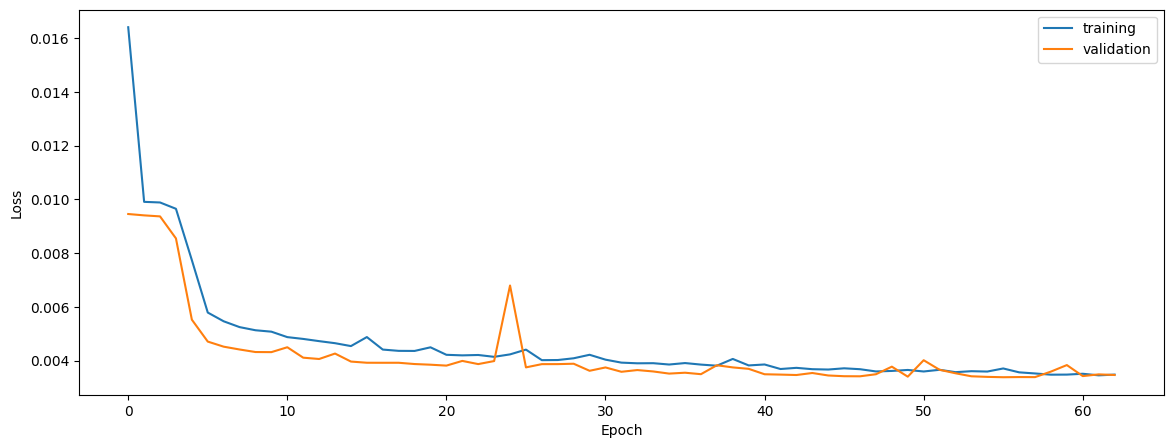

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


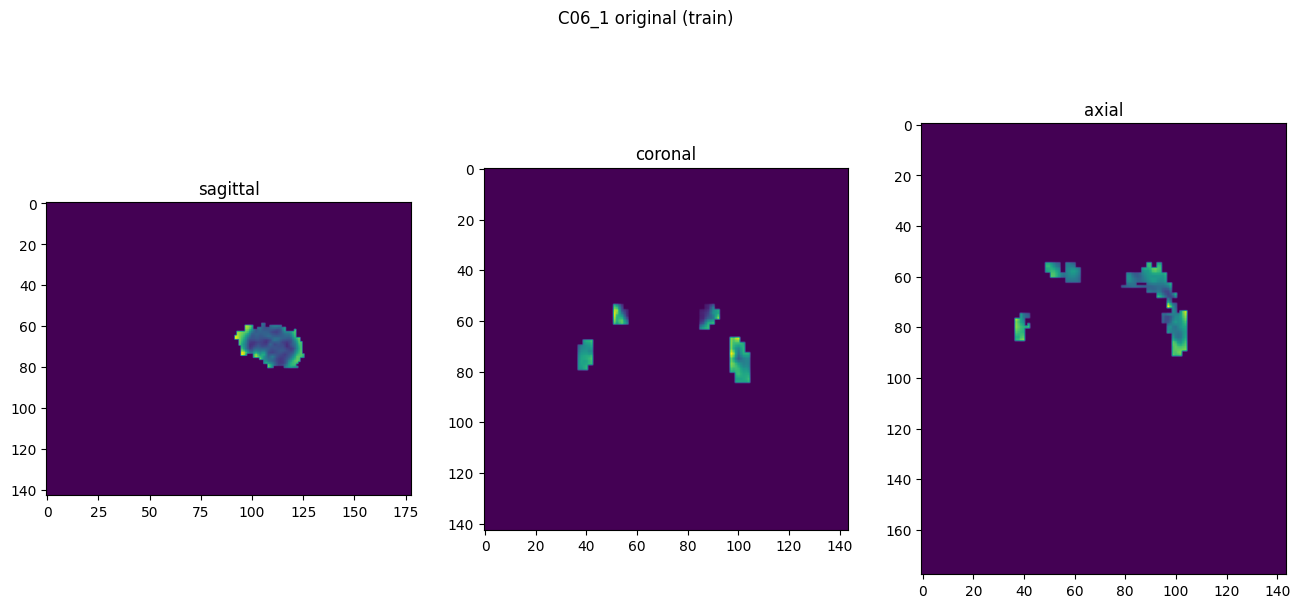

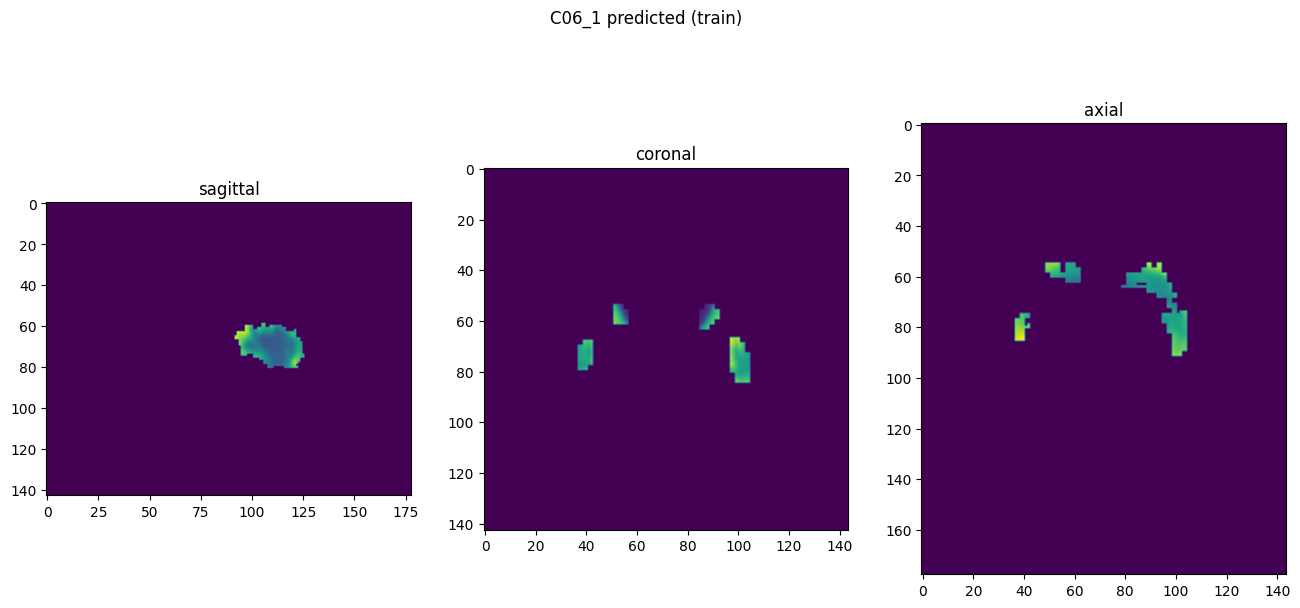

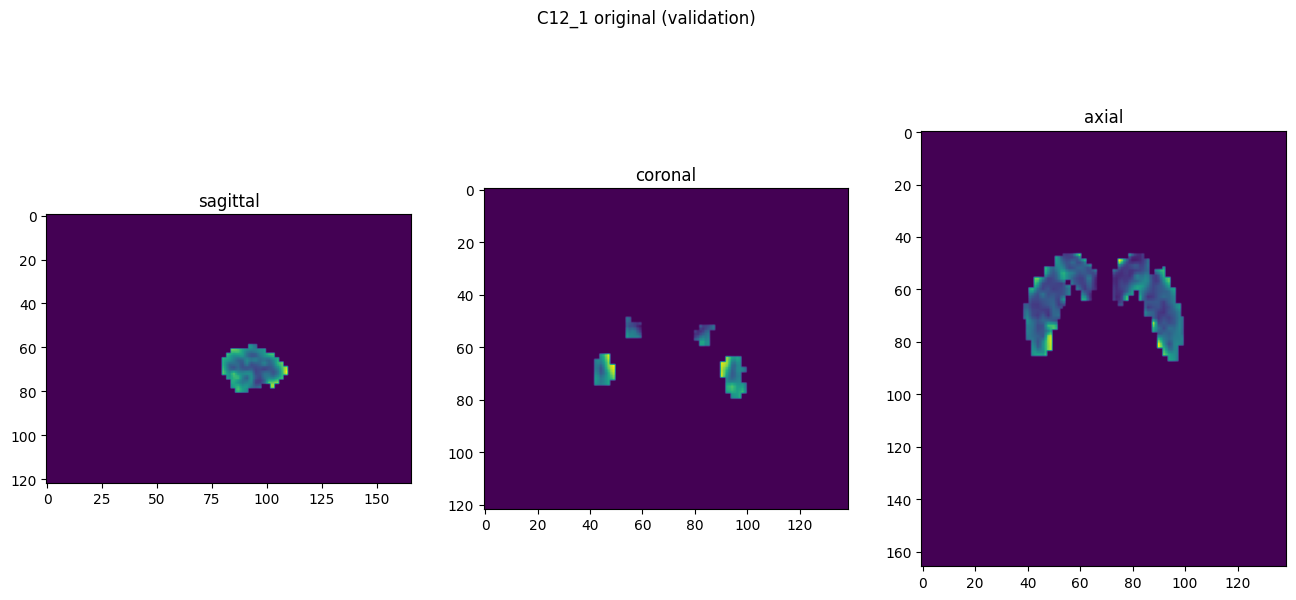

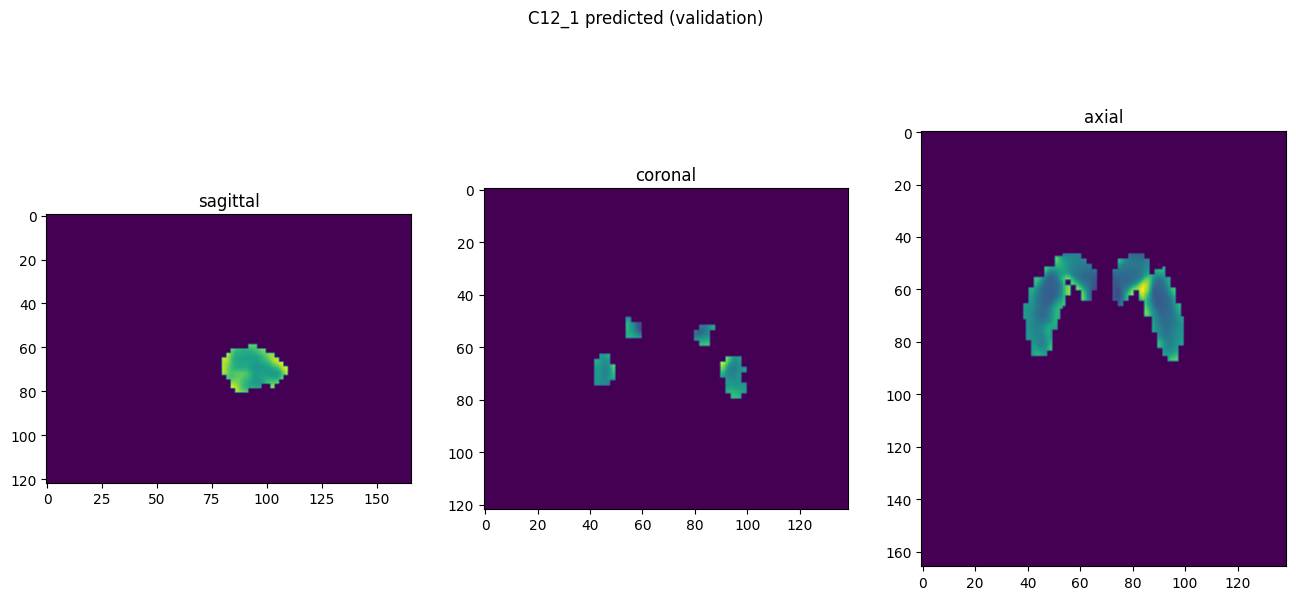

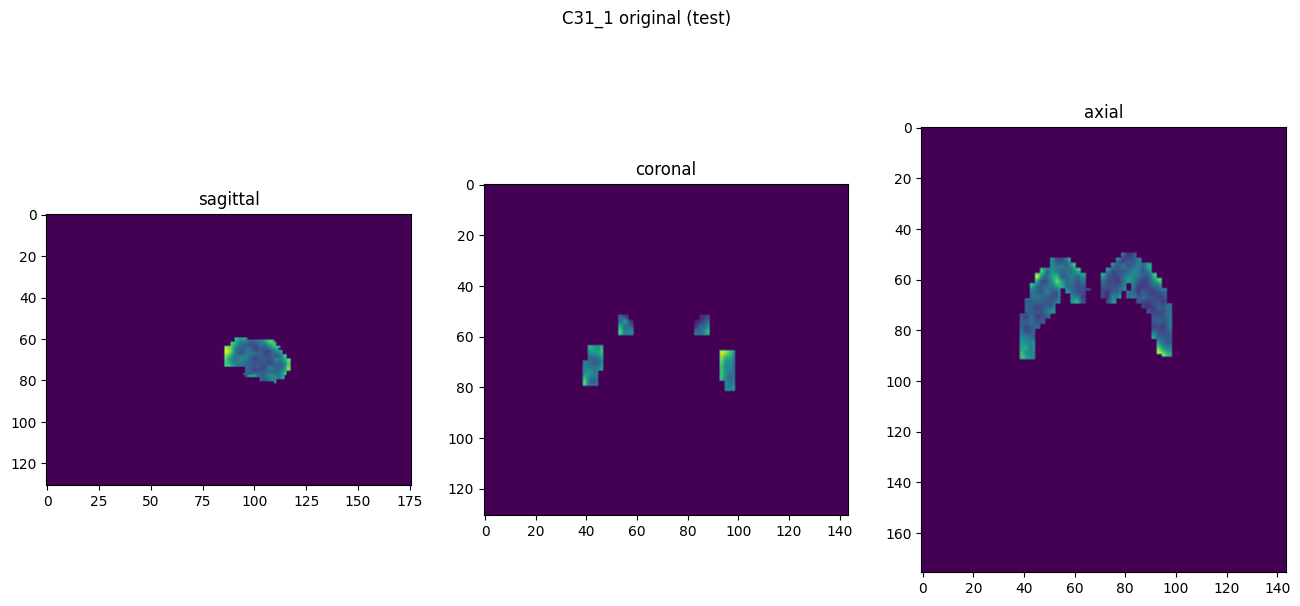

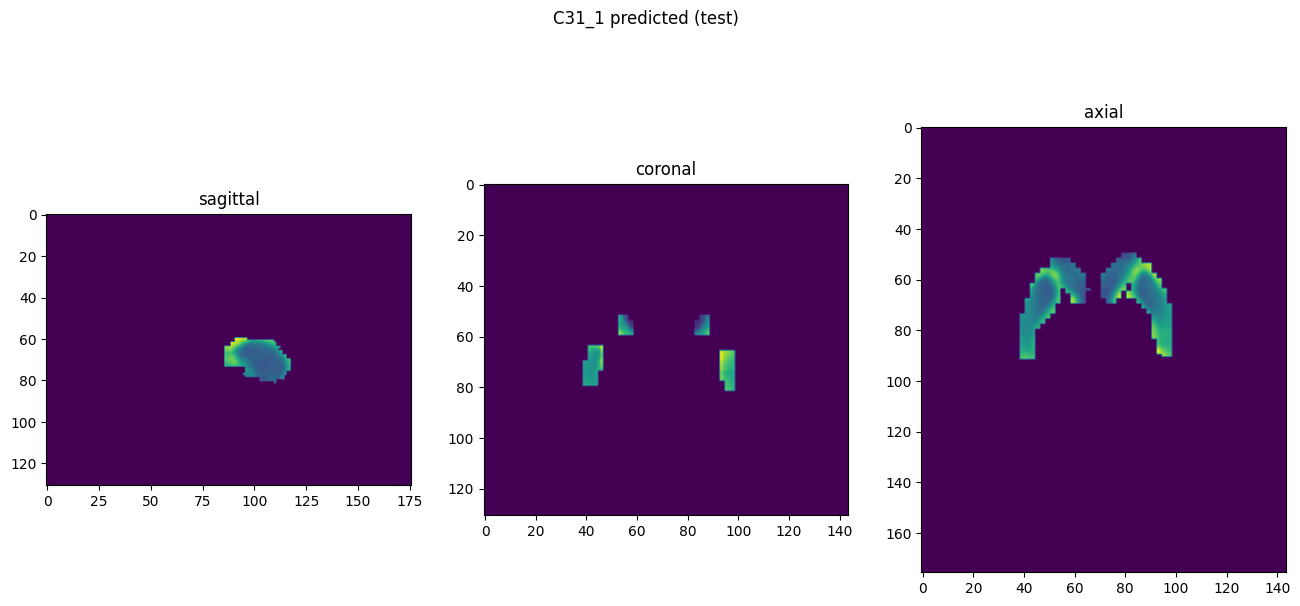

In [10]:
showResults(model, gen, threshold=None, background=False)